In [ ]:
import pandas as pd
import numpy as np
from plotnine import * 
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader as pdr

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# **Case 1**

In [ ]:
# Importing data from github
url = 'https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/MidtermCase1Data.csv'
raw = pd.read_csv(url)
raw.head()

Week   Sales  Week.1  Sales.1  Week.2  Sales.2  Week.3  Sales.3
0     1  102450      27   114980      53   167170      79   181560
1     2   98930      28   130250      54   161200      80   202130
2     3   91550      29   128070      55   166710      81   183740
3     4  111940      30   135970      56   156430      82   191880
4     5  103380      31   142370      57   162440      83   197950

**Data Preparation:** we can see by looking at the dataframe that the way the data is laid out is not useful. We need to get all the week and sales values in chronological order in two different columns. To do this, we will stack the data to reshape our dataframe.

In [ ]:
# Cleaning data by stacking Week and Sales columns correctly

# Splitting raw data into parts
rawpart1 = pd.DataFrame(raw[["Week", "Sales"]])
rawpart2 = pd.DataFrame(raw[["Week.1", "Sales.1"]])
rawpart3 = pd.DataFrame(raw[["Week.2", "Sales.2"]])
rawpart4 = pd.DataFrame(raw[["Week.3", "Sales.3"]])

# Renaming columns in all parts
rawpart2.rename(columns={'Week.1': 'Week', 'Sales.1': 'Sales'}, inplace=True)
rawpart3.rename(columns={'Week.2': 'Week', 'Sales.2': 'Sales'}, inplace=True)
rawpart4.rename(columns={'Week.3': 'Week', 'Sales.3': 'Sales'}, inplace=True)

# Appending raw data by parts to form new df
df = rawpart1.append(rawpart2, ignore_index = True)
df = df.append(rawpart3, ignore_index = True)
df = df.append(rawpart4, ignore_index = True)

df.tail()

Week   Sales
99    100  174720
100   101  169580
101   102  180310
102   103  154080
103   104  163560

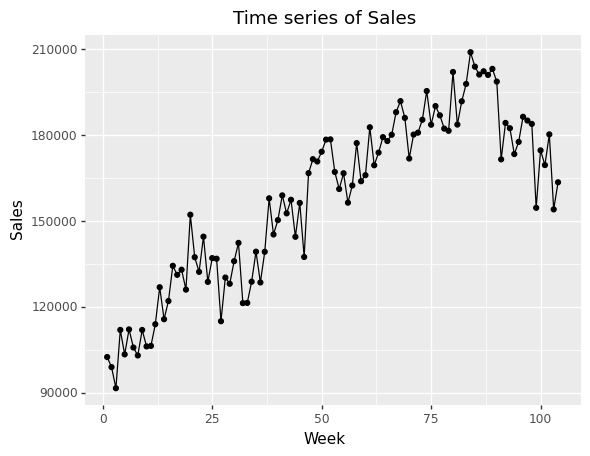

<ggplot: (8777538855165)>

In [ ]:
# Plotting Time Series
(
    ggplot(df,aes('Week','Sales', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of Sales") +
  xlab("Week") + ylab("Sales")
    )

**Data Analysis:** Looking at the sales over time we can observe there is an upwards trend, that then decreases at at around week 88, which coincides with the release of the competitor's product.

In [ ]:
# Calculating means of Before New Product and After New Product data to see difference
df['M0'] = df.loc[:86,'Sales'].mean()
df.loc[87:,'M0'] = df.loc[87:,'Sales'].mean()

# Assigning groups
df['Group'] = "Before New Product"
df.loc[87:,'Group'] = "After New Product"

df['NP'] = 0
df.loc[87:,'NP'] = 1

df

Week   Sales             M0               Group  NP
0       1  102450  153324.827586  Before New Product   0
1       2   98930  153324.827586  Before New Product   0
2       3   91550  153324.827586  Before New Product   0
3       4  111940  153324.827586  Before New Product   0
4       5  103380  153324.827586  Before New Product   0
..    ...     ...            ...                 ...  ..
99    100  174720  179117.058824   After New Product   1
100   101  169580  179117.058824   After New Product   1
101   102  180310  179117.058824   After New Product   1
102   103  154080  179117.058824   After New Product   1
103   104  163560  179117.058824   After New Product   1

[104 rows x 5 columns]

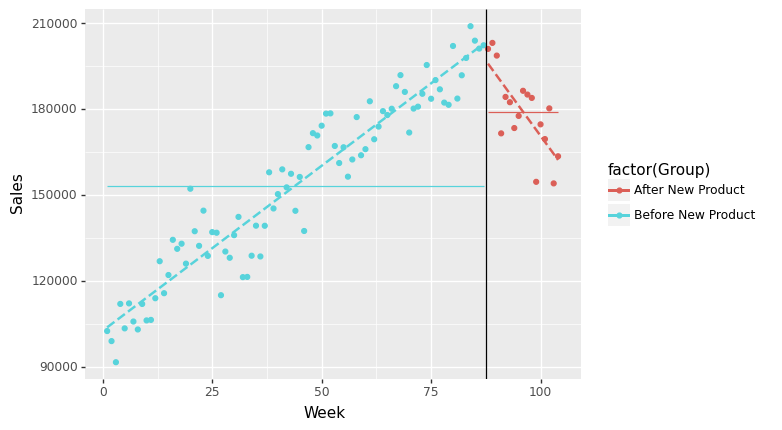

<ggplot: (8777538738209)>

In [ ]:
# Creating scatterplot with averages for both groups
(
    ggplot(df,aes('Week','Sales',color='factor(Group)')) + geom_point() + geom_line(aes('Week','M0'))
     + geom_vline(xintercept=87.5,color='black') + geom_smooth(aes(color='factor(Group)'), method='lm',se=False,show_legend=False, linetype="dashed")
    )

In this visualization, we can see clearly the increasing sales trend before week 88, that then turns into a decreasing trend after (dashed lines). Additionally, we can see the mean lines of before and after the intervention. Because there is not enough data after week 88, the mean is higher. Because we know the data is trending downwards after the intervention, we know this is not accurate as with more weeks we would see a lower mean. This suggests the change is gradual and not abrupt.

In [ ]:
# Regression model
M1 = smf.ols('Sales ~ NP',data = df).fit()
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     11.58
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           0.000954
Time:                        07:29:50   Log-Likelihood:                -1213.7
No. Observations:                 104   AIC:                             2431.
Df Residuals:                     102   BIC:                             2437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.533e+05   3064.471     50.033      0.0

In [ ]:
# Store fitted values of model in data table
df['M1'] = M1.fittedvalues
df["M1residuals"] = M1.resid

In [ ]:
# Create a scatter plot of M1 to observe change
(
    ggplot(df, aes('Week','Sales')) + geom_point() + 
 geom_vline(xintercept=87.5,color='red') + geom_point(aes('Week','M1'),color='blue')
)

<ggplot: (8777564683541)>

We make a regression model to test the data for the abrupt change. As the p-value is lower than our alpha (0.05), we can conclude that there is no statistically signficant evidence of an abrupt change resulting in the sales decreasing after week 88.

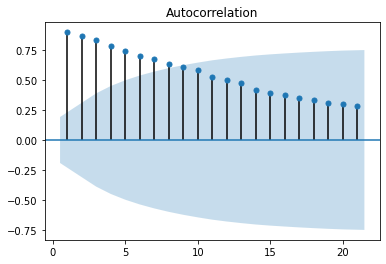

In [ ]:
# Plotting ACF of residuals
plot_acf(df['M1residuals'],missing='drop',zero=False);

In [ ]:
# Plotting PACF
plot_pacf(df.loc[df['M1residuals'].notna(),'M1residuals'],zero=False);

In [ ]:
# Checking list for Ramp
df.loc[87:,].shape
list(range(18))[1:]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [ ]:
# Create Trend variable
df["Trend"] = list(range(len(df)))

# Create a ramp variable to model gradual change in Sales after New Product
df['Ramp'] = 0
df.loc[87:,'Ramp'] = list(range(18))[1:]

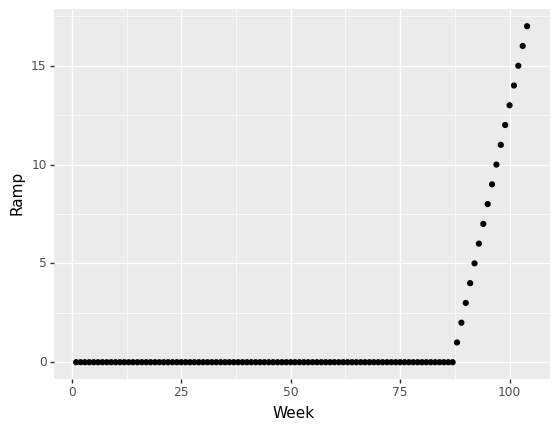

<ggplot: (8777535933077)>

In [ ]:
# Visualize Ramp variable
(
    ggplot(df,aes('Week','Ramp')) + geom_point()
)

In [ ]:
# Build a regression model to assess the significance of the gradual effect of the intervention
M2 = smf.ols('Sales ~ Trend + Ramp',data = df).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     491.7
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           8.77e-53
Time:                        07:29:52   Log-Likelihood:                -1095.8
No. Observations:                 104   AIC:                             2198.
Df Residuals:                     101   BIC:                             2206.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.041e+05   1930.860     53.911      0.0

In [ ]:
# Save Model fitted values & residuals
df['M2'] = M2.fittedvalues
df['M2residuals'] = M2.resid

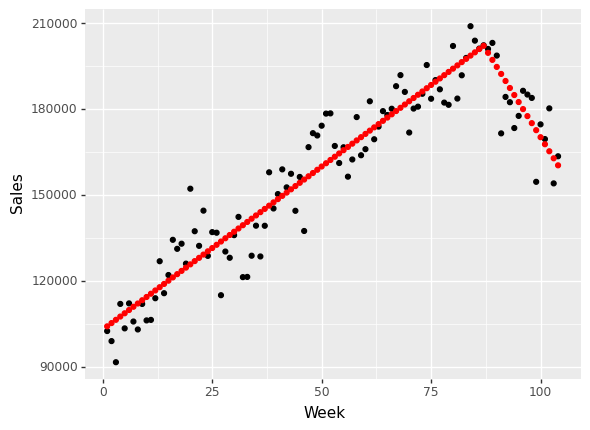

<ggplot: (8777535909605)>

In [ ]:
# Create a scatter plot of Sales with results of ramp model
(
    ggplot(df, aes('Week','Sales')) + geom_point() + 
 geom_point(aes('Week','M2'),color='red')
)

We conclude that the change is a gradual one due to the intervention (introduction of new product in market). Hence, we use a ramp variable in M2 to model the gradual change. As we can see in the visualization, this model is much more accurate in terms of conveying the changing trend of the data. The model also tells us sales decrease on average by almost 3,600 each year after the product is introduced. The model's Rsquared value is 0.907, which tells us it is a good fit for the data.

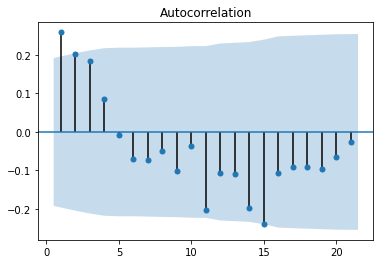

In [ ]:
# Plotting ACF of residuals
plot_acf(df['M2residuals'],missing='drop',zero=False);

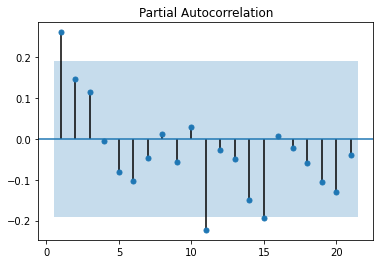

In [ ]:
# Plotting PACF
plot_pacf(df.loc[df['M2residuals'].notna(),'M2residuals'],zero=False);

In [ ]:
# compare M1 and M2 visually
(
    ggplot(df, aes('Week','Sales')) + geom_point() + 
 geom_point(aes('Week','M1'),color='red') +
 geom_point(aes('Week','M2'),color='blue',size= 0.5)
)

<ggplot: (8777535878433)>

In order to quantify the effect of the introduction of the new product, we must create a new model. In this model, we only allow it to look at all data before week 88 in order to tell us what Sales would have been if the new product was not introduced. We also remove the Ramp element from the model as we are ignoring the intervention.

In [ ]:
# Using model to quantify the effect of the introduction of the new product

# Without data after new product
df["SalesBefore"] = df["Sales"]
df.loc[87:, "SalesBefore"] = np.nan

M3 = smf.ols('SalesBefore ~ Trend',data = df).fit()

df['M3'] = M3.predict(df)

df["Prediction"] = "Fitted Values"
df.loc[87:, "Prediction"] = "Forecast"

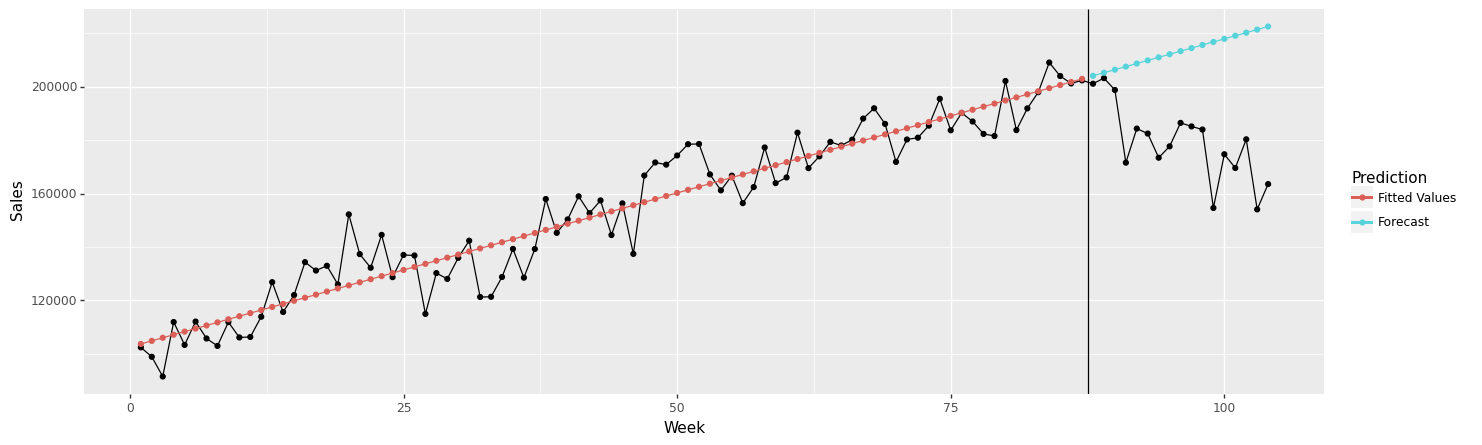

<ggplot: (8777535752053)>

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df,aes('Week','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Week','M3',color='Prediction')) + geom_line(aes('Week','M3',color='Prediction')) +
 geom_vline(xintercept = 87.5) + theme(figure_size=(16, 5))
)

As we can see from this visualization, the Sales would have continued to trend upwards without the introduction of the new product. In order to quantify this, we must look at the area between the Forecast and Actual data after week 88.

In [ ]:
# impact of COVID = actual Sales(Week 88 onwards) - prediction assuming new product introduction has not happened(Week 88 onwards)
round(df.loc[87:, "Sales"].sum() - df.loc[87:, "M3"].sum())

-580941

In [ ]:
# Calculating impact in percentage scale
print((((df.loc[87:, "M3"].sum() - df.loc[87:, "Sales"].sum()) / df.loc[87:, "M3"].sum()))*100)

16.02184213649867


In conclusion, we can see that the effect of the introduction of the new product has meant almost 581,000 less sales for the company in the given period and a 16% decrease in relation to what the prediction of no product introduction is. If we had more data, due to the downwards trend after the intervention, I would guess that the sales and % value lost would grow even more across time.

# **Case 2**

In [ ]:
# Scraping data from website
url = 'https://www.census.gov/econ/currentdata/dbsearch?program=MARTS&startYear=1992&endYear=2022&categories%5B%5D=443&dataType=SM&geoLevel=US&notAdjusted=1&submit=GET+DATA&releaseScheduleId='
raw2 = pd.read_html(url)

In [ ]:
# Putting raw data in dataframe
df2 = pd.DataFrame(raw2[0])

# Stacking columns to get tidy df
df2 = df2.set_index(["Year"]).stack().reset_index()
df2.columns = ["Year", "Month", "Sales"]

# Creating month/year column
monthyear_list = []

# Appending items to list
for i in range(0, len(df2)):
  monthyear = str(df2["Month"][i]) + str("-") + str(df2["Year"][i])
  monthyear_list.append(monthyear)

# Inserting new column in df
df2.insert(2, 'MonthYear', monthyear_list)

# Creating Time column to correctly graph data
df2.insert(3, "Time", list(range(0, len(df2))))

df2.head(14)

Year Month MonthYear  Time   Sales
0   1992   Jan  Jan-1992     0  3657.0
1   1992   Feb  Feb-1992     1  3490.0
2   1992   Mar  Mar-1992     2  3669.0
3   1992   Apr  Apr-1992     3  3527.0
4   1992   May  May-1992     4  3571.0
5   1992   Jun  Jun-1992     5  3788.0
6   1992   Jul  Jul-1992     6  3930.0
7   1992   Aug  Aug-1992     7  3817.0
8   1992   Sep  Sep-1992     8  3795.0
9   1992   Oct  Oct-1992     9  4014.0
10  1992   Nov  Nov-1992    10  4419.0
11  1992   Dec  Dec-1992    11  7014.0
12  1993   Jan  Jan-1993    12  4105.0
13  1993   Feb  Feb-1993    13  3735.0

After scraping the data from the internet, we must make sure the data is in a useable format. We stack the year column in order to get a tidy dataframe, and add a MonthYear column for reference, as well as a Time column for easier visualization.

In [ ]:
# Plot Sales data
(
    ggplot(df2,aes('Time','Sales', group = 1)) + geom_point() + geom_line() + ggtitle("Time Series of Sales") +
  xlab("Time") + ylab("Sales") + theme(figure_size=(16, 5)) + geom_smooth(aes('Time', 'Sales'), method='lm',se=False,show_legend=False, linetype="dashed")
)

<ggplot: (8777535859489)>

Here we can see the timeseries of Sales for the given period. We note there is a slight positive trend throughout the given period (perhaps not too significant, but we will include it in the model anyways). We can also see a high degree of seasonality. It seems like in the month of December, sales spike every year. This could be due to Christmas-time shopping tendencies, when people will be buying more electronics as gifts for friends and family. We can also observe a sharp dip towards the end of the time period (impact of COVID on shopping). The seasonality also seems to be multiplicative, as the December sales spikes seem to grow from time 0 to time 200.

In [ ]:
# Finding correct COVID start period
df2.loc[47]
df2.loc[338]

Year             2020
Month             Mar
MonthYear    Mar-2020
Time              338
Sales          5778.0
Name: 338, dtype: object

In [ ]:
# Scenario 1
# Train set: 01/1992 to 12/2016 -- Testing set: 01/2017 to 12/2017

df2.loc[300]

Year             2017
Month             Jan
MonthYear    Jan-2017
Time              300
Sales          7034.0
Name: 300, dtype: object

In [ ]:
# Scenario 2
# Train set: 01/1992 to 12/2017 -- Testing set: 01/2018 to 12/2018

df2.loc[312]

Year             2018
Month             Jan
MonthYear    Jan-2018
Time              312
Sales          7287.0
Name: 312, dtype: object

In [ ]:
# Scenario 3
# Train set: 01/1992 to 12/2018 -- Testing set: 01/2019 to 12/2019

df2.loc[324]

Year             2019
Month             Jan
MonthYear    Jan-2019
Time              324
Sales          7197.0
Name: 324, dtype: object

In [ ]:
# Create Trend column
df2["Trend"] = list(range(0, len(df2)))

# Setting COVID impacted months
df2['COV'] = 0
df2.loc[338:340,'COV'] = 1

# Make a copy of column Sales and replace testing set with nan, as well as everything after
# Scenario 1
df2['SalesTrain1'] = df2['Sales']
df2.loc[300:,'SalesTrain1'] = np.nan

# Scenario 2
df2['SalesTrain2'] = df2['Sales']
df2.loc[312:,'SalesTrain2'] = np.nan

# Scenario 3
df2['SalesTrain3'] = df2['Sales']
df2.loc[324:,'SalesTrain3'] = np.nan

In order to create a model to assess the impact of COVID on sales, we must use a training and test splits to see how our model performs with known data. We want to see how the model performs across all scenarios, and have created a Trend column as well as creating three SalesTrain columns with our desired training sets for Scenarios 1 to 3.

In [ ]:
# Regression Models
M1_S1 = smf.ols('SalesTrain1 ~ Trend + C(Month)', data = df2).fit()
M1_S2 = smf.ols('SalesTrain2 ~ Trend + C(Month)', data = df2).fit()
M1_S3 = smf.ols('SalesTrain3 ~ Trend + C(Month)', data = df2).fit()

In [ ]:
df2['M1S1'] = M1_S1.fittedvalues
df2.loc[300:, 'M1S1'] = M1_S1.predict(df2.loc[300:])
df2['M1S1residuals'] = M1_S1.resid

df2['M1S2'] = M1_S2.fittedvalues
df2.loc[312:, 'M1S2'] = M1_S2.predict(df2.loc[312:])
df2['M1S2residuals'] = M1_S2.resid

df2['M1S3'] = M1_S3.fittedvalues
df2.loc[324:, 'M1S3'] = M1_S3.predict(df2.loc[324:])
df2['M1S3residuals'] = M1_S3.resid

In [ ]:
(
    ggplot(df2.loc[df2['Time']<312],aes('Time','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Time','M1S1'),color='red') + geom_line(aes('Time','M1S1'),color='red')+
    geom_vline(xintercept=300,color='blue') + ggtitle("M1 - Scenario 1")
    + theme(figure_size=(16, 5))
)

<ggplot: (8777538738321)>

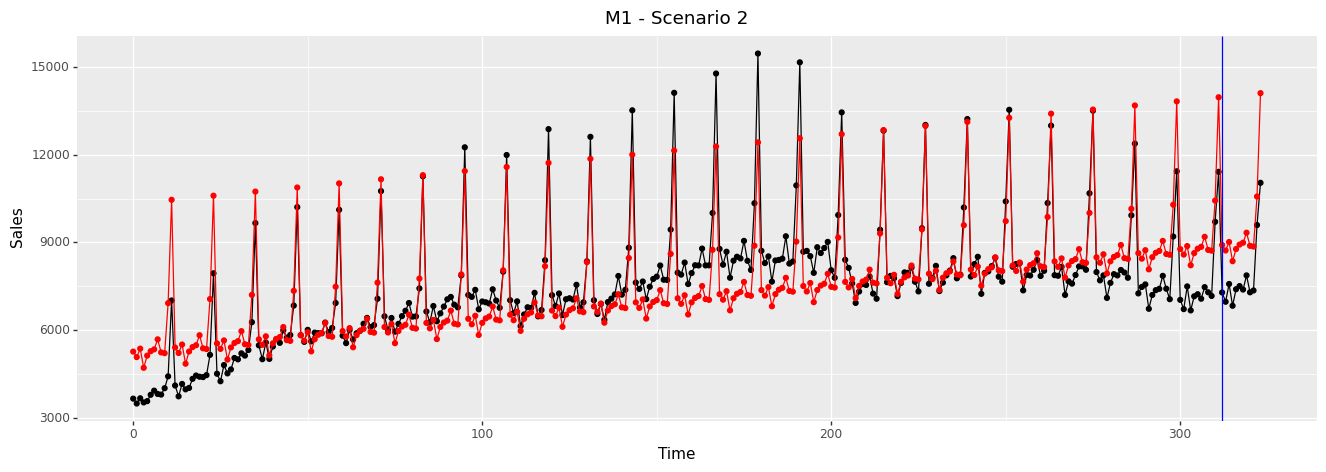

<ggplot: (8777535975565)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<324],aes('Time','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Time','M1S2'),color='red') + geom_line(aes('Time','M1S2'),color='red')+
    geom_vline(xintercept=312,color='blue') + ggtitle("M1 - Scenario 2")
    + theme(figure_size=(16, 5))
)

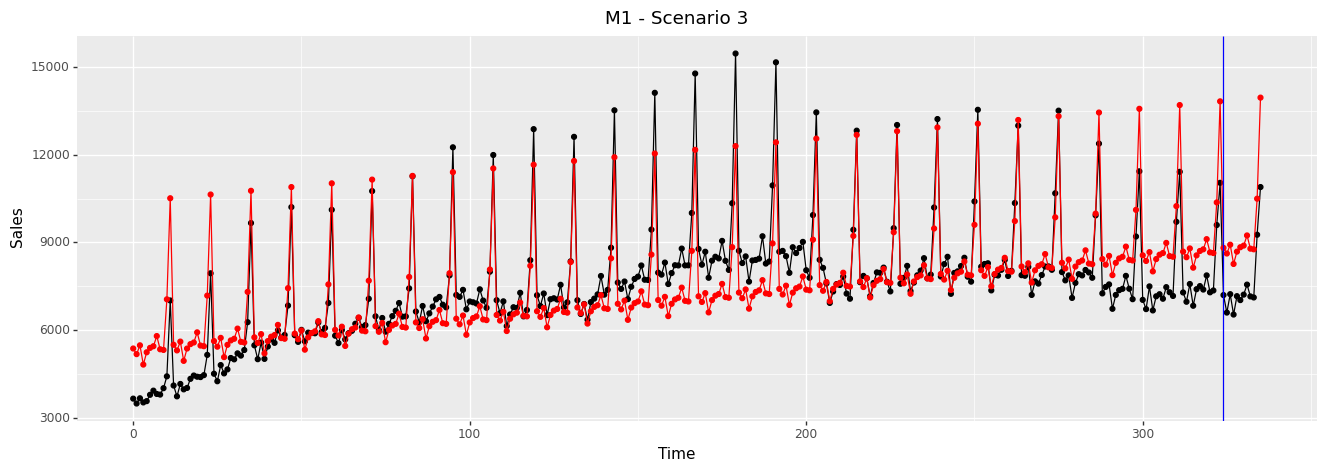

<ggplot: (8777535982741)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<336],aes('Time','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Time','M1S3'),color='red') + geom_line(aes('Time','M1S3'),color='red')+
    geom_vline(xintercept=324,color='blue') + ggtitle("M1 - Scenario 3")
    + theme(figure_size=(16, 5))
)

When visualizing our regression models we see that the model has done an OK job at fitting the data, but the prediction for the 3 test sets seems to be a little too optimistic. This could be due to other patterns that our models have not captured, and for this we must look at the graphs of residuals to incorporate any additional patterns (lags).

The model, however, does a good job at caputring the seasonality of the data, as it suggests that sales in December are on average 5,652 million higher than in April (the intercept).

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 70 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 70 rows containing missing values.


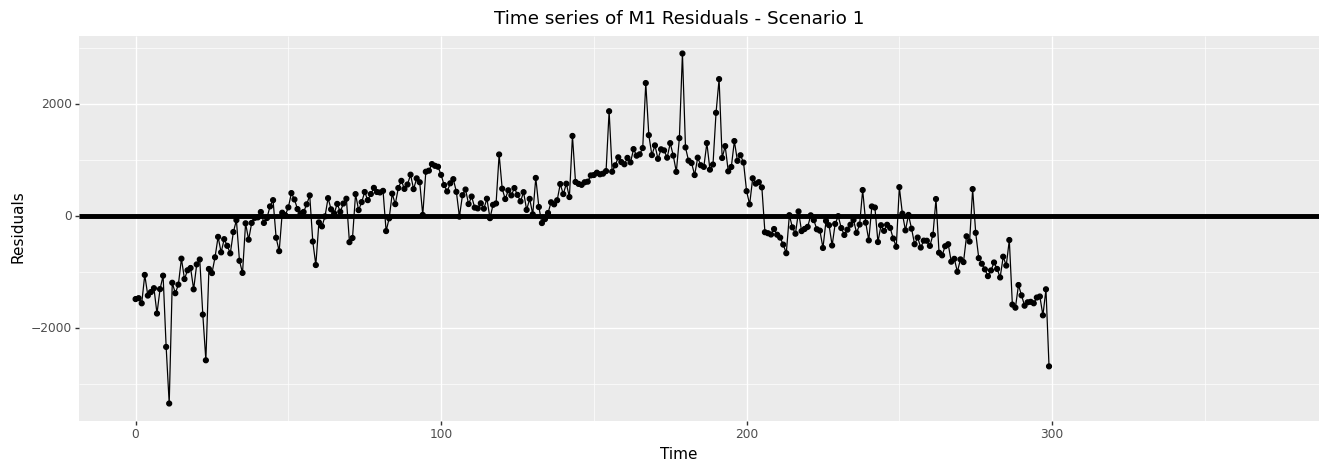

<ggplot: (8777535856521)>

In [ ]:
# Plot M1 Residuals
(
    ggplot(df2,aes('Time','M1S1residuals', group = 1)) + geom_point() + geom_line() +
  ggtitle("Time series of M1 Residuals - Scenario 1") + geom_hline(yintercept=0, size=2) +
  xlab("Time") + ylab("Residuals") + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 58 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 58 rows containing missing values.


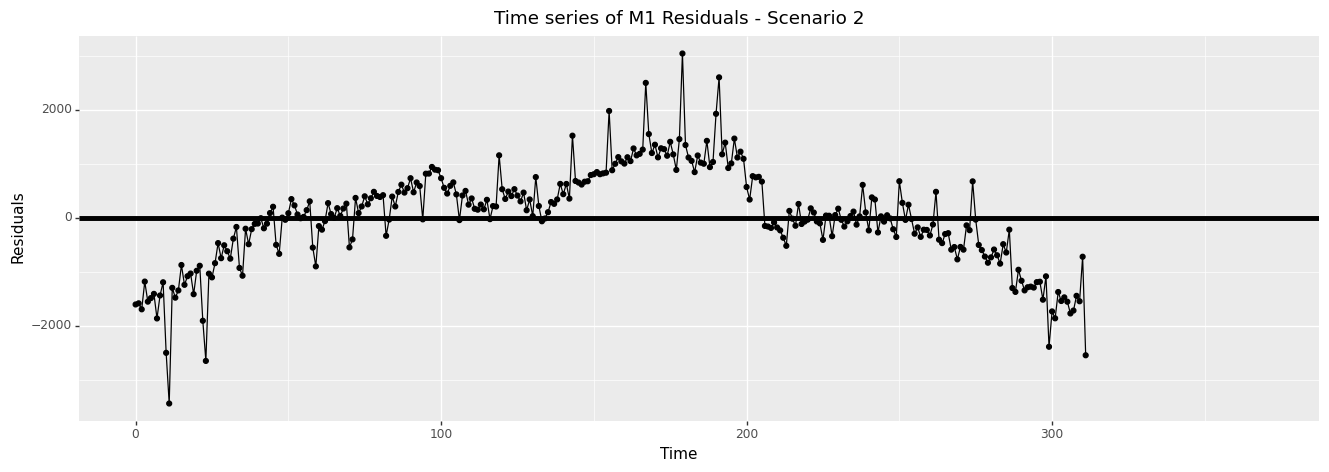

<ggplot: (8777536007145)>

In [ ]:
# Plot M1 Residuals
(
    ggplot(df2,aes('Time','M1S2residuals', group = 1)) + geom_point() + geom_line() +
  ggtitle("Time series of M1 Residuals - Scenario 2") + geom_hline(yintercept=0, size=2) +
  xlab("Time") + ylab("Residuals") + theme(figure_size=(16, 5))
)

In [ ]:
# Plot M1 Residuals
(
    ggplot(df2,aes('Time','M1S3residuals', group = 1)) + geom_point() + geom_line() +
  ggtitle("Time series of M1 Residuals - Scenario 3") + geom_hline(yintercept=0, size=2) +
  xlab("Time") + ylab("Residuals") + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 46 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 46 rows containing missing values.


<ggplot: (8777535927641)>

When looking at the M1 residuals, we can see that they have a pattern and do not look like graph noise. This indicates that we must observe the ACF and PACF in order to gain an insight to any statistically significant dependences that were not captured by this Regression Model.

Scenario 1
Scenario 2
Scenario 3


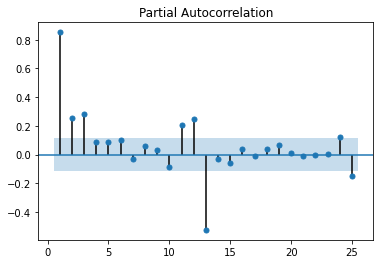

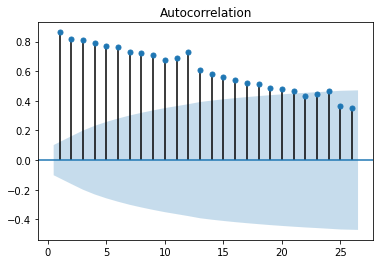

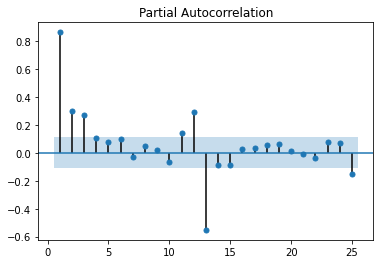

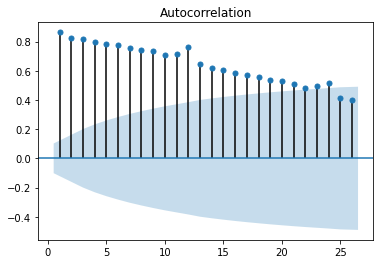

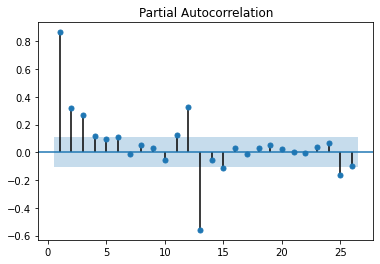

In [ ]:
# Is there any statistically significant dependence in data that was not captured by our model?
print("Scenario 1")
plot_acf(df2['M1S1residuals'],missing='drop',zero=False);
plot_pacf(df2.loc[df2['M1S1residuals'].notna(),'M1S1residuals'],zero=False);
print("Scenario 2")
plot_acf(df2['M1S2residuals'],missing='drop',zero=False);
plot_pacf(df2.loc[df2['M1S2residuals'].notna(),'M1S2residuals'],zero=False);
print("Scenario 3")
plot_acf(df2['M1S3residuals'],missing='drop',zero=False);
plot_pacf(df2.loc[df2['M1S3residuals'].notna(),'M1S3residuals'],zero=False);

In [ ]:
# Implementing lags from PAFC into our dataframe
df2['SalesTrainLag1'] = df2['Sales'].shift(1)
df2['SalesTrainLag2'] = df2['Sales'].shift(2)
df2['SalesTrainLag3'] = df2['Sales'].shift(3)
df2['SalesTrainLag11'] = df2['Sales'].shift(11)
df2['SalesTrainLag12'] = df2['Sales'].shift(12)
df2['SalesTrainLag13'] = df2['Sales'].shift(13)
df2['SalesTrainLag25'] = df2['Sales'].shift(25)

Looking at our ACF graph, we see that the model has significant lags, so we turn our attention to the PACF graph. We have indentified 7 lags that lie outside our confidence interval, making them statistically significant so we incorporate them into our dataframe by implementing lags in the data.

In [ ]:
# New Regression models w/ lags
M2_S1 = smf.ols('SalesTrain1 ~ Trend + C(Month) + SalesTrainLag1 + SalesTrainLag2 + SalesTrainLag3 + SalesTrainLag11 + SalesTrainLag12 + SalesTrainLag13 + SalesTrainLag25', data = df2).fit()
M2_S2 = smf.ols('SalesTrain2 ~ Trend + C(Month) + SalesTrainLag1 + SalesTrainLag2 + SalesTrainLag3 + SalesTrainLag11 + SalesTrainLag12 + SalesTrainLag13 + SalesTrainLag25', data = df2).fit()
M2_S3 = smf.ols('SalesTrain3 ~ Trend + C(Month) + SalesTrainLag1 + SalesTrainLag2 + SalesTrainLag3 + SalesTrainLag11 + SalesTrainLag12 + SalesTrainLag13 + SalesTrainLag25', data = df2).fit()

In [ ]:
df2['M2S1'] = M2_S1.fittedvalues
df2.loc[300:, 'M2S1'] = M2_S1.predict(df2.loc[300:])
df2['M2S1residuals'] = M2_S1.resid

df2['M2S2'] = M2_S2.fittedvalues
df2.loc[312:, 'M2S2'] = M2_S2.predict(df2.loc[312:])
df2['M2S2residuals'] = M2_S2.resid

df2['M2S3'] = M2_S3.predict(df2)
df2.loc[324:, 'M2S3'] = M2_S3.predict(df2)
df2['M2S3residuals'] = M2_S3.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 95 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 95 rows containing missing values.


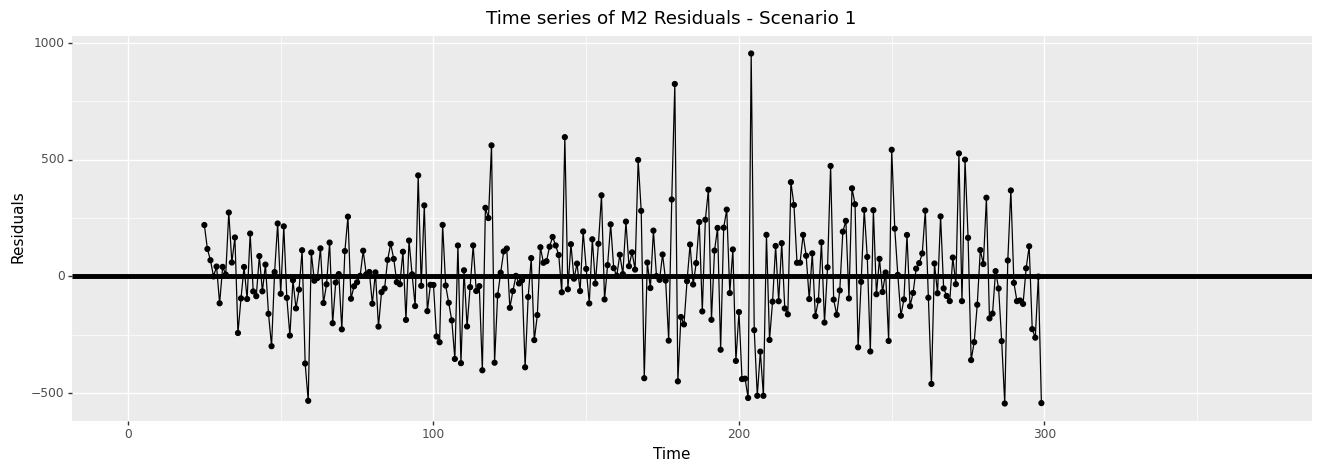

<ggplot: (8777533165021)>

In [ ]:
# Plot M2 Residuals
(
    ggplot(df2,aes('Time','M2S1residuals', group = 1)) + geom_point() + geom_line() +
  ggtitle("Time series of M2 Residuals - Scenario 1") + geom_hline(yintercept=0, size=2) +
  xlab("Time") + ylab("Residuals") + theme(figure_size=(16, 5))
)

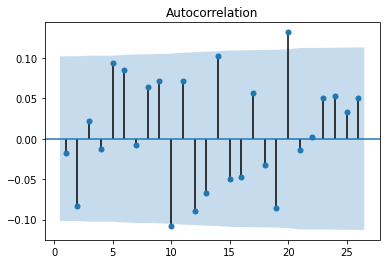

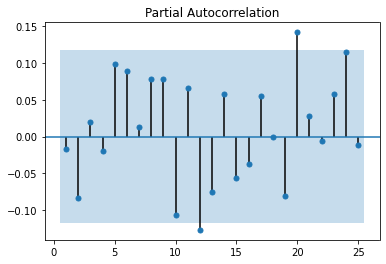

In [ ]:
# Checking ACF and PACF
plot_acf(df2['M2S1residuals'],missing='drop',zero=False);
plot_pacf(df2.loc[df2['M2S1residuals'].notna(),'M2S1residuals'],zero=False);

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


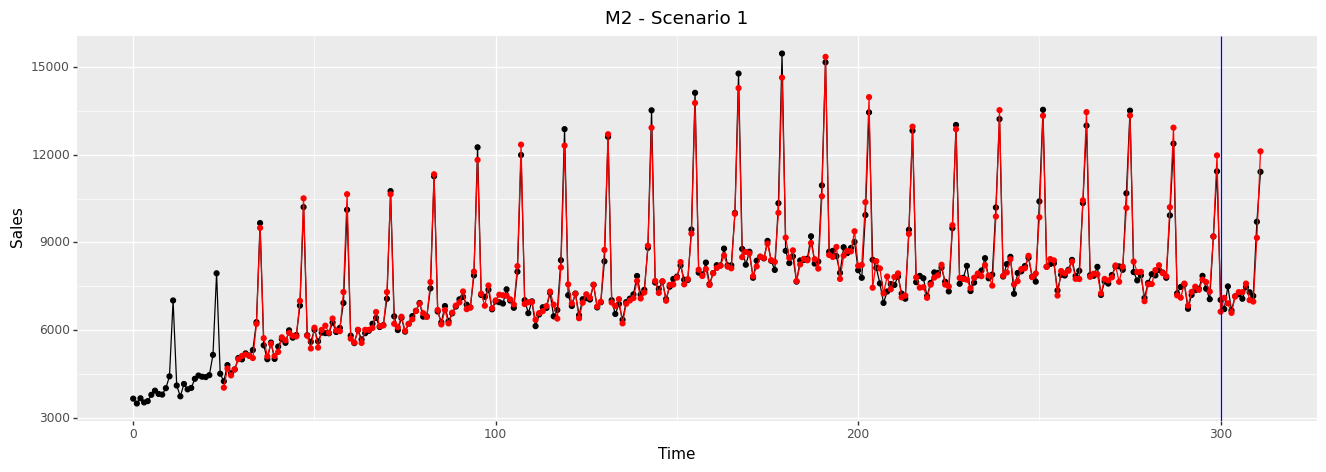

<ggplot: (8777533012229)>

In [ ]:
# Plotting M2
(
    ggplot(df2.loc[df2['Time']<312],aes('Time','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Time','M2S1'),color='red') + geom_line(aes('Time','M2S1'),color='red')+
    geom_vline(xintercept=300,color='blue') + ggtitle("M2 - Scenario 1")
    + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


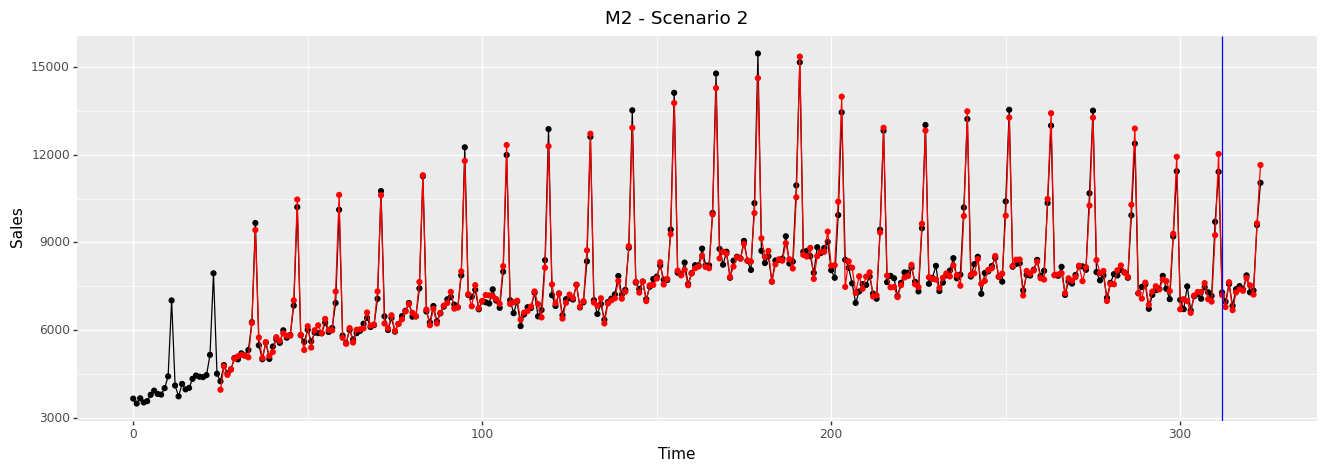

<ggplot: (8777532948409)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<324],aes('Time','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Time','M2S2'),color='red') + geom_line(aes('Time','M2S2'),color='red')+
    geom_vline(xintercept=312,color='blue') + ggtitle("M2 - Scenario 2")
    + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


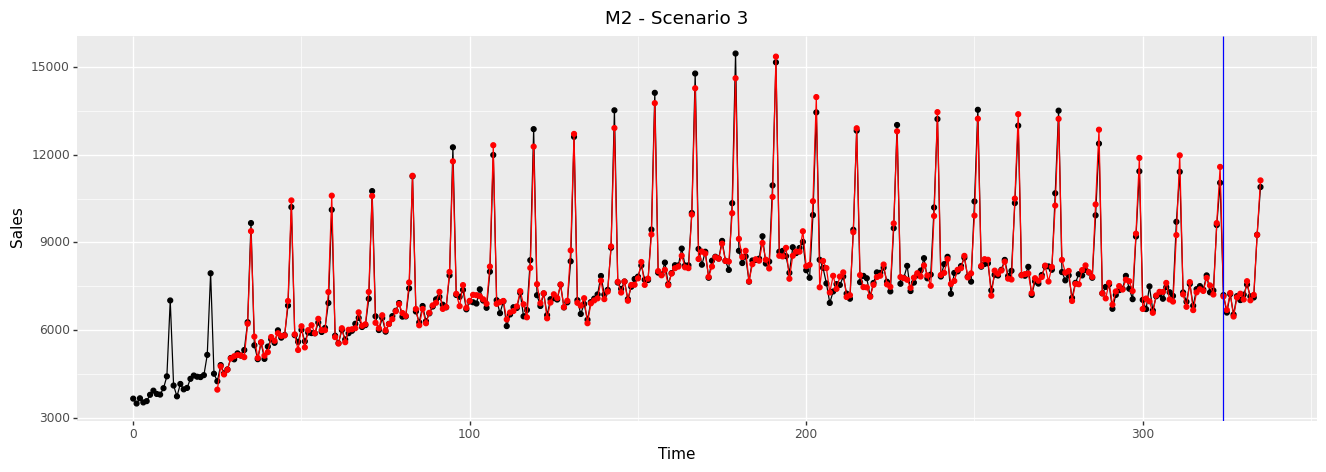

<ggplot: (8777533074037)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<336],aes('Time','Sales')) + geom_point() + geom_line() +
    geom_point(aes('Time','M2S3'),color='red') + geom_line(aes('Time','M2S3'),color='red')+
    geom_vline(xintercept=324,color='blue') + ggtitle("M2 - Scenario 3")
    + theme(figure_size=(16, 5))
)

Our Regression model with lags (M2) seems to capture the patterns of the data much more accurately for all scenarios. The residuals graph resembles graph noise more closely, and we see by looking at the ACF and PACF graphs that we have eliminated most statistically significant dependences. The Rsquared of M2 is higher than M1, suggesting that it is a better fit for the data.

In [ ]:
# Creating Exponential Smoothing model for all scenarios
M3_S1 = ExponentialSmoothing(df2.loc[:299,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
M3_S2 = ExponentialSmoothing(df2.loc[:311,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
M3_S3 = ExponentialSmoothing(df2.loc[:323,'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

In [ ]:
# Saving fitted values, predictions and residuals for all scenarios
# Scenario 1
df2.loc[300:, 'M3S1'] = M3_S1.forecast(12)
df2.loc[:299,'M3S1'] = M3_S1.fittedvalues
df2['M3S1residuals'] = M3_S1.resid

df2['Prediction1'] = 'Fitted values'
df2.loc[300:,'Prediction1'] = 'Forecast'

# Scenario 2
df2.loc[312:, 'M3S2'] = M3_S2.forecast(12)
df2.loc[:311,'M3S2'] = M3_S2.fittedvalues
df2['M3S2residuals'] = M3_S2.resid

df2['Prediction2'] = 'Fitted values'
df2.loc[312:,'Prediction2'] = 'Forecast'

# Scenario 3
df2.loc[324:, 'M3S3'] = M3_S3.forecast(12)
df2.loc[:323,'M3S3'] = M3_S3.fittedvalues
df2['M3S3residuals'] = M3_S3.resid

df2['Prediction3'] = 'Fitted values'
df2.loc[324:,'Prediction3'] = 'Forecast'


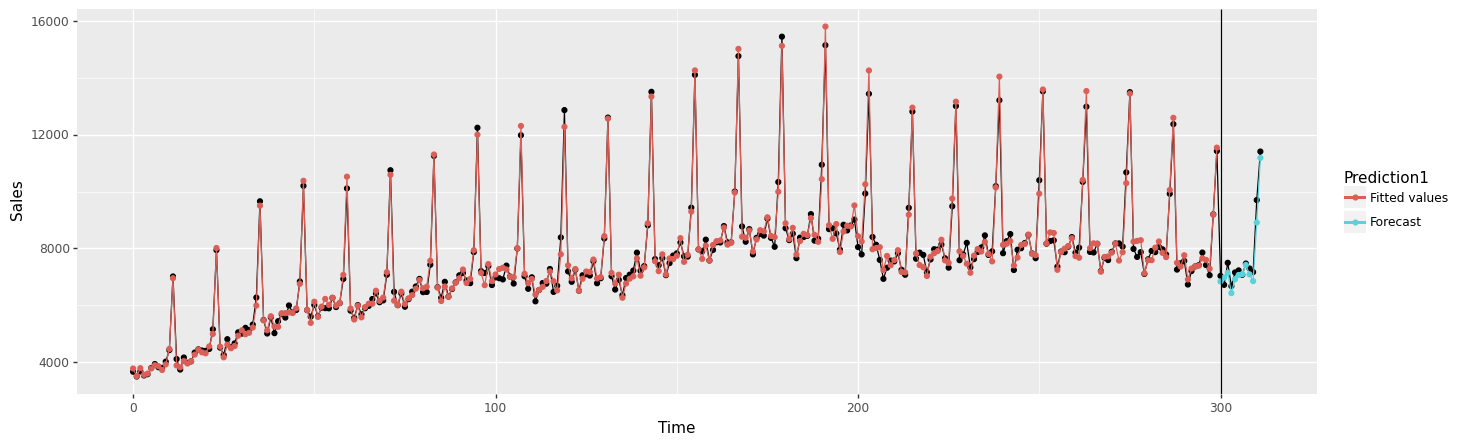

<ggplot: (8777535796997)>

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecasts for each scenario 
(
    ggplot(df2.loc[df2['Time']<312],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M3S1',color='Prediction1')) + geom_line(aes('Time','M3S1',color='Prediction1')) +
 geom_vline(xintercept = 300) + theme(figure_size=(16, 5))
)

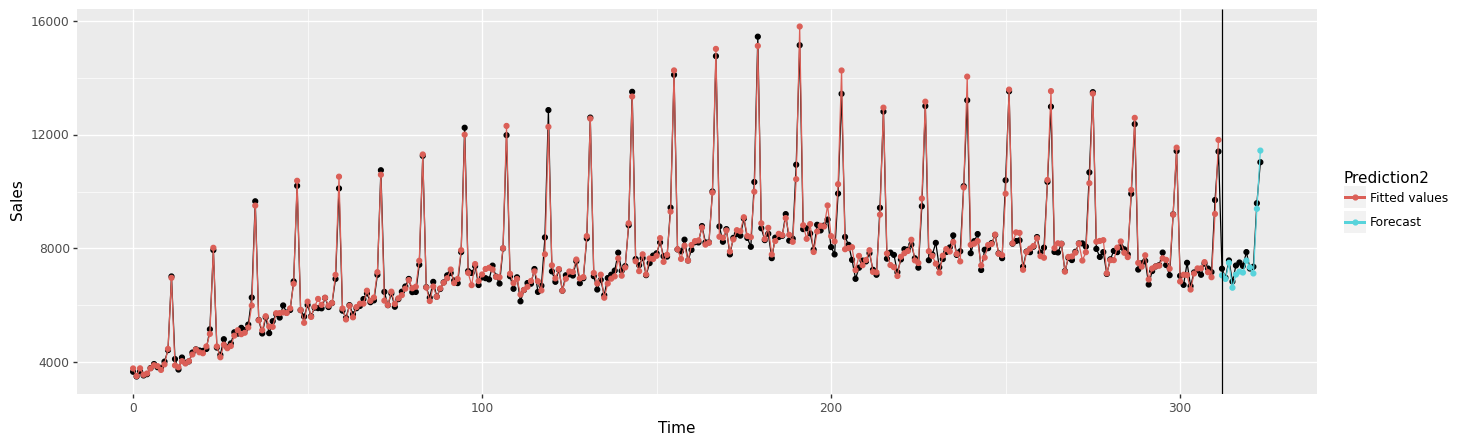

<ggplot: (8777535859133)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<324],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M3S2',color='Prediction2')) + geom_line(aes('Time','M3S2',color='Prediction2')) +
 geom_vline(xintercept = 312) + theme(figure_size=(16, 5))
)

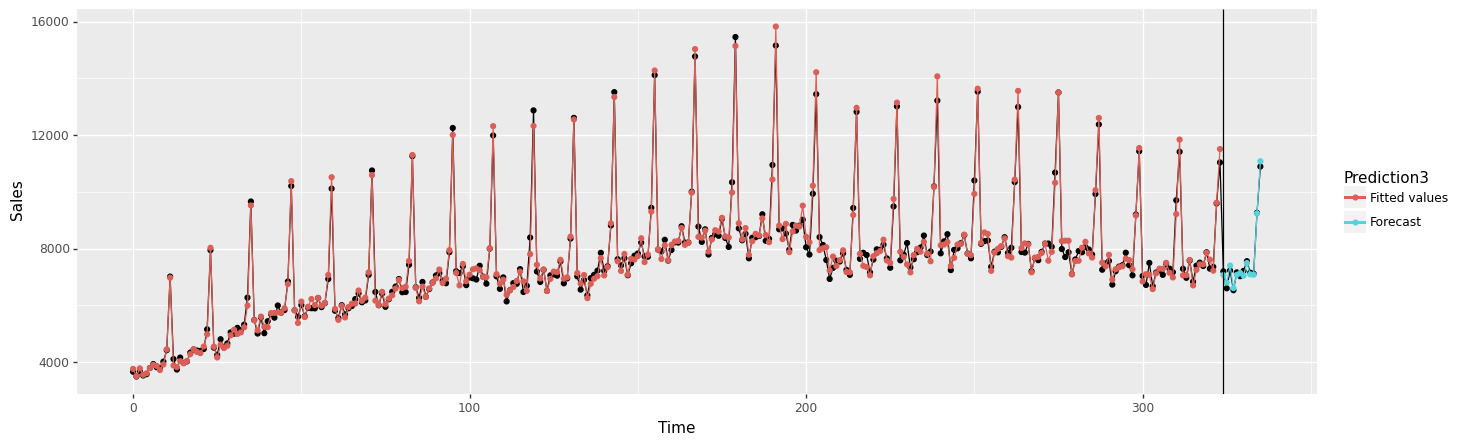

<ggplot: (8777535834021)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<336],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M3S3',color='Prediction3')) + geom_line(aes('Time','M3S3',color='Prediction3')) +
 geom_vline(xintercept = 324) + theme(figure_size=(16, 5))
)

For our next model (M3), we use an Exponential Smoothing model incorporating the additive trend and multiplicative seasonality of the data. We can see in our visualization that it has done a good job at capturing all the patterns in the data, and the forecast for the training set is close to the actual data.

In [ ]:
# Test which model is more suitable

In [ ]:
# Building RMSE and MAPE functions
def rmse(actual,predicted):
    return round(((actual - predicted)**2).mean()**0.5,2)

def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)

# Building accuracy function using above functions
def accuracy(actual,predicted,n):
    n_train = n
    n_test = n + 12
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (n>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train + 1:n_test],predicted[n_train+ 1:n_test])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train + 1:n_test],predicted[n_train+ 1:n_test])
    return accuracy_metrics

In [ ]:

print("Regression Model - Scenario 1:")
acc_M2S1 = accuracy(df2['Sales'], df2['M2S1'], 299)
acc_M2S1

Regression Model - Scenario 1:


RMSE MAPE(%)
Training set  220.38    2.03
Testing set   321.22    3.49

In [ ]:
print("Regression Model - Scenario 2:")
acc_M2S2 = accuracy(df2['Sales'], df2['M2S2'], 311)
acc_M2S2

Regression Model - Scenario 2:


RMSE MAPE(%)
Training set  226.27     2.1
Testing set   128.01    1.56

In [ ]:
print("Regression Model - Scenario 3:")
acc_M2S3 = accuracy(df2['Sales'], df2['M2S3'], 323)
acc_M2S3

Regression Model - Scenario 3:


RMSE MAPE(%)
Training set  226.04     2.1
Testing set   109.76     1.3

In [ ]:
print("Exponential Smoothing Model - Scenario 1:")
acc_M3S1 = accuracy(df2['Sales'], df2['M3S1'], 299)
acc_M3S1

Exponential Smoothing Model - Scenario 1:


RMSE MAPE(%)
Training set  210.63     2.0
Testing set   322.95    3.37

In [ ]:
print("Exponential Smoothing Model - Scenario 2:")
acc_M3S2 = accuracy(df2['Sales'], df2['M3S2'], 311)
acc_M3S2

Exponential Smoothing Model - Scenario 2:


RMSE MAPE(%)
Training set  212.15    2.03
Testing set   223.91    2.67

In [ ]:
print("Exponential Smoothing Model - Scenario 3:")
acc_M3S3 = accuracy(df2['Sales'], df2['M3S3'], 323)
acc_M3S3

Exponential Smoothing Model - Scenario 3:


RMSE MAPE(%)
Training set  210.81    2.01
Testing set   117.23    1.45

In [ ]:
print("Average MAPE for M2: " + str((acc_M2S1.iloc[1,1] + acc_M2S2.iloc[1,1] + acc_M2S3.iloc[1,1]) / 3))
print("Average MAPE for M3: " + str((acc_M3S1.iloc[1,1] + acc_M3S2.iloc[1,1] + acc_M3S3.iloc[1,1]) / 3))

Average MAPE for M2: 2.1166666666666667
Average MAPE for M3: 2.4966666666666666


We build a function that will calculate the RMSE and MAPE for our training and testing sets, and we use it to assess the fit of our models. We want to take the average MAPE for both models across all 3 scenarios.

Since the average MAPE for M2 (2.12) is lower than the average MAPE for M3 (2.50), so we will use the Regression Model (M2) for COVID impact evaluation.

In [ ]:
# COVID Period
df2.loc[338:340]

Year Month MonthYear  Time   Sales  Trend  COV  SalesTrain1  SalesTrain2  \
338  2020   Mar  Mar-2020   338  5778.0    338    1          NaN          NaN   
339  2020   Apr  Apr-2020   339  3013.0    339    1          NaN          NaN   
340  2020   May  May-2020   340  3914.0    340    1          NaN          NaN   

     SalesTrain3  ...  M2S3residuals  M3S1  M3S1residuals  Prediction1  M3S2  \
338          NaN  ...            NaN   NaN            NaN     Forecast   NaN   
339          NaN  ...            NaN   NaN            NaN     Forecast   NaN   
340          NaN  ...            NaN   NaN            NaN     Forecast   NaN   

     M3S2residuals  Prediction2  M3S3  M3S3residuals  Prediction3  
338            NaN     Forecast   NaN            NaN     Forecast  
339            NaN     Forecast   NaN            NaN     Forecast  
340            NaN     Forecast   NaN            NaN     Forecast  

[3 rows x 38 columns]

In [ ]:
# Creating Train set with no data during COVID period
df2["SalesNoCOV"] = df2["Sales"]
df2.loc[338:, "SalesNoCOV"] = np.nan

# Using "winning" regression model to assess COVID impact
M2_W = smf.ols('SalesNoCOV ~ Trend + C(Month)', data = df2).fit()

df2['M2W'] = M2_W.predict(df2)
df2['M2Wresiduals'] = M2_W.resid

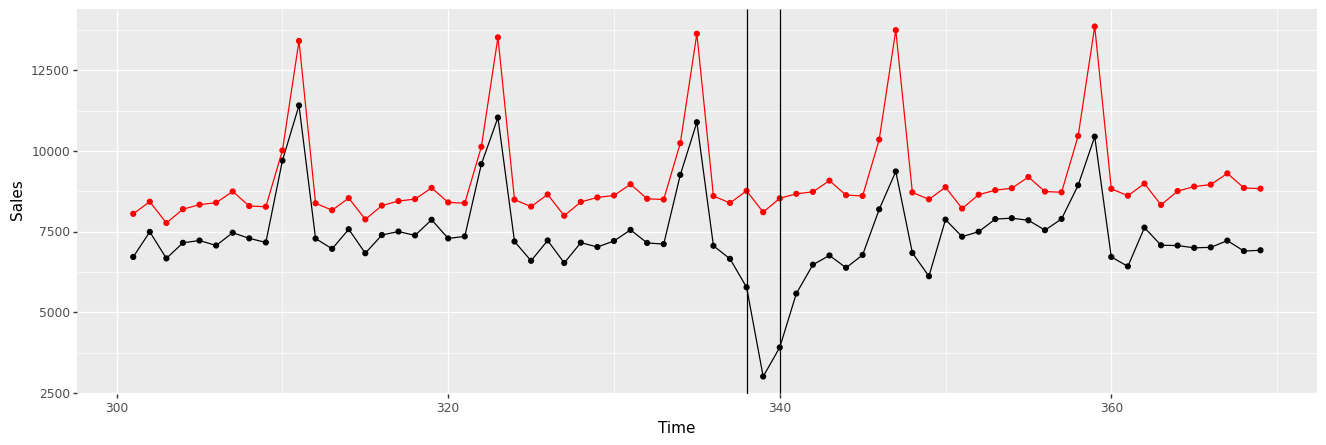

<ggplot: (8777535989713)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']>300],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M2W'), color="red") + geom_line(aes('Time','M2W'), color="red") +
 geom_vline(xintercept = 338) + geom_vline(xintercept = 340) + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 32 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 32 rows containing missing values.


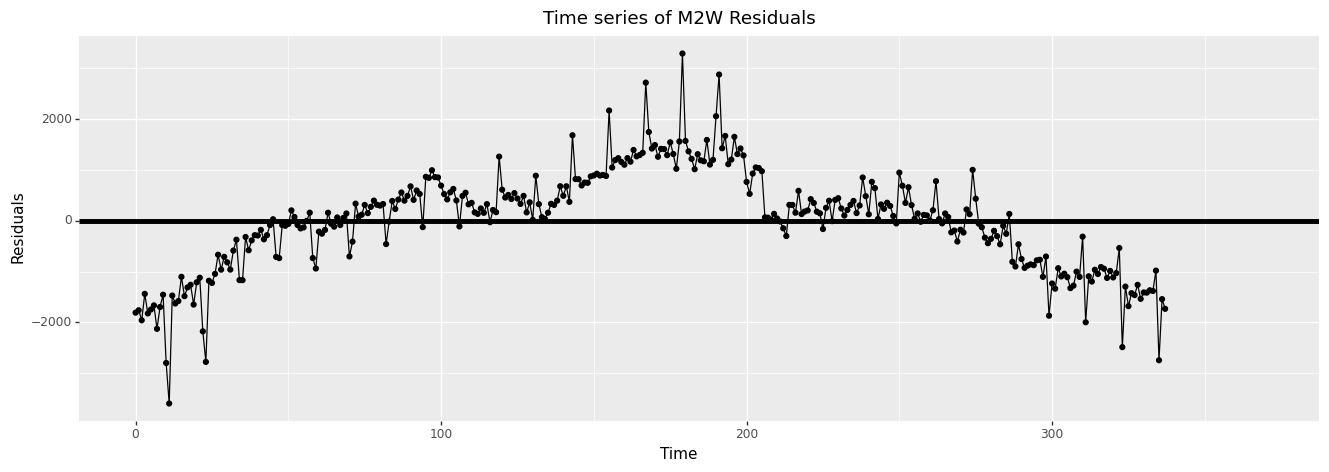

<ggplot: (8777535901313)>

In [ ]:
# Plot M2W Residuals
(
    ggplot(df2,aes('Time','M2Wresiduals', group = 1)) + geom_point() + geom_line() +
  ggtitle("Time series of M2W Residuals") + geom_hline(yintercept=0, size=2) +
  xlab("Time") + ylab("Residuals") + theme(figure_size=(16, 5))
)

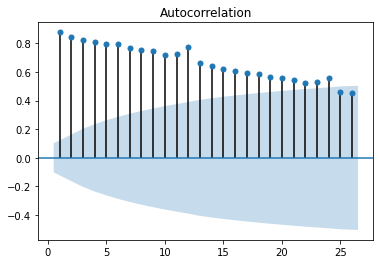

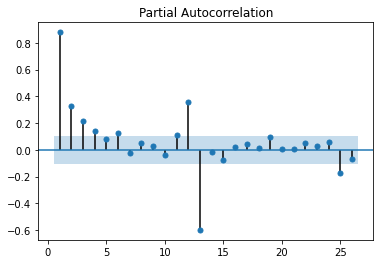

In [ ]:
# Checking ACF and PACF
plot_acf(df2['M2Wresiduals'],missing='drop',zero=False);
plot_pacf(df2.loc[df2['M2Wresiduals'].notna(),'M2Wresiduals'],zero=False);

In [ ]:
# Implementing lags from PAFC into our dataframe
df2['SalesWLag1'] = df2['Sales'].shift(1)
df2['SalesWLag2'] = df2['Sales'].shift(2)
df2['SalesWLag3'] = df2['Sales'].shift(3)
df2['SalesWLag4'] = df2['Sales'].shift(4)
df2['SalesWLag12'] = df2['Sales'].shift(12)
df2['SalesWLag13'] = df2['Sales'].shift(13)
df2['SalesWLag25'] = df2['Sales'].shift(25)

In [ ]:
M2_W2 = smf.ols('SalesNoCOV ~ Trend + C(Month) + SalesWLag1 + SalesWLag2 + SalesWLag3 + SalesWLag4 + SalesWLag12 + SalesWLag13 + SalesWLag25', data = df2).fit()

In [ ]:
# Save fitted values
df2["M2W2"] = M2_W2.fittedvalues

# Use loop to automate data prediction
for i in range(338, len(df2) + 1):
  df2.loc[i, "SalesWLag1"] = df2.loc[i-1, "SalesNoCOV"]
  df2.loc[i, "SalesWLag2"] = df2.loc[i-2, "SalesNoCOV"]
  df2.loc[i, "SalesWLag3"] = df2.loc[i-3, "SalesNoCOV"]
  df2.loc[i, "SalesWLag4"] = df2.loc[i-4, "SalesNoCOV"]
  df2.loc[i, "SalesWLag12"] = df2.loc[i-12, "SalesNoCOV"]
  df2.loc[i, "SalesWLag13"] = df2.loc[i-13, "SalesNoCOV"]
  df2.loc[i, "SalesWLag25"] = df2.loc[i-25, "SalesNoCOV"]

  df2.loc[i, "SalesNoCOV"] = M2_W2.predict(df2.loc[[i]]).values
  df2.loc[i, "M2W2"] = M2_W2.predict(df2.loc[[i]]).values

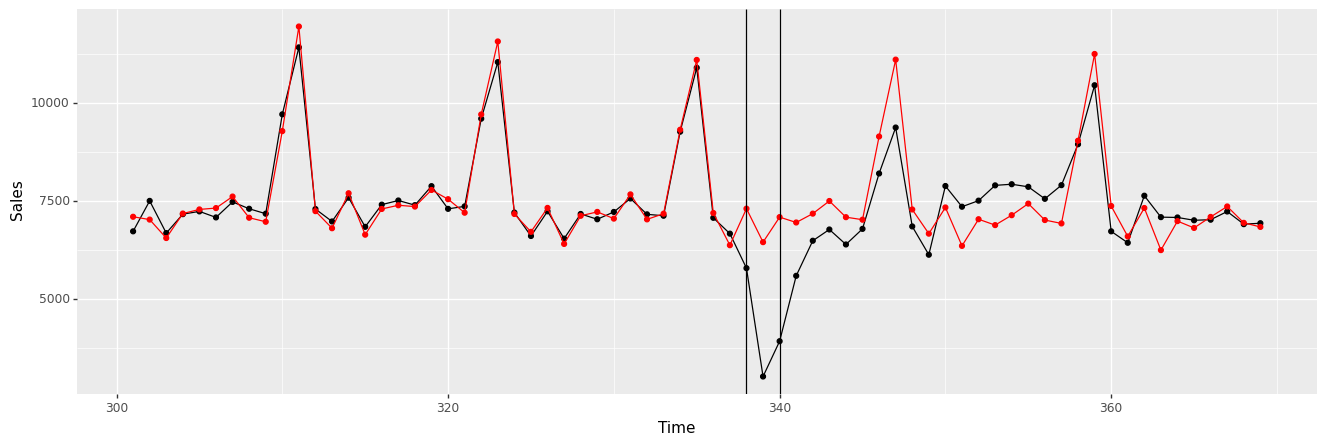

<ggplot: (8777535850921)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']>300],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M2W2'), color="red") + geom_line(aes('Time','M2W2'), color="red") +
 geom_vline(xintercept = 338) + geom_vline(xintercept = 340) + theme(figure_size=(16, 5))
)

We use the champion model with the lags implemented (M2W2) to forecast the data during the COVID period and beyond. Looking at the visualization, we can see the large difference between the actual COVID impact (black) and the prediction of sales assuming COVID did not happen within the period.

In [ ]:
# impact of COVID = actual Sales(03/2020 to 05/2020) - prediction assuming COVID has not happened(03/2020 to 05/2020)
round(df2.loc[338:340, "Sales"].sum() - df2.loc[338:340, "M2W2"].sum())

-8114

In [ ]:
# Calculating impact in percentage scale
# % impact = (total  predicted GP during covid assuming covid has not happened - total actual 
# GP during covid) / total  predicted GP during covid assuming covid has not happened
print((((df2.loc[338:340, "M2W2"].sum() - df2.loc[338:340, "Sales"].sum()) / df2.loc[338:340, "M2W2"].sum()))*100)

38.97507799159565


To quantify the impact of COVID, we can take our actual and M2W2 data within the COVID span and subtract one from another.

The impact of COVID was **8,114 million sales lost.**

In the percentage scale, this equates to **39.0% sales lost.**

In [ ]:
# Predicting data for next 12 months
# Forecast df
fc_list = list(range(len(df2) -1, len(df2) -1 + 12))


# Using Ex. Smoothing model with all present data
M4 = ExponentialSmoothing(df2.loc[:368, 'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()
df2["M4"] = M4.fittedvalues

# Creating predictions df
dfFuture = pd.DataFrame({'Time':fc_list,
                         'FutureForecast':M4.forecast(12)})
dfFuture.head(12)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


Time  FutureForecast
369   370     7012.244485
370   371     8501.313186
371   372    10299.957977
372   373     6979.013695
373   374     6589.084637
374   375     7476.387695
375   376     6272.439450
376   377     6572.364940
377   378     7273.614971
378   379     7481.068039
379   380     7590.810495
380   381     7163.536550

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


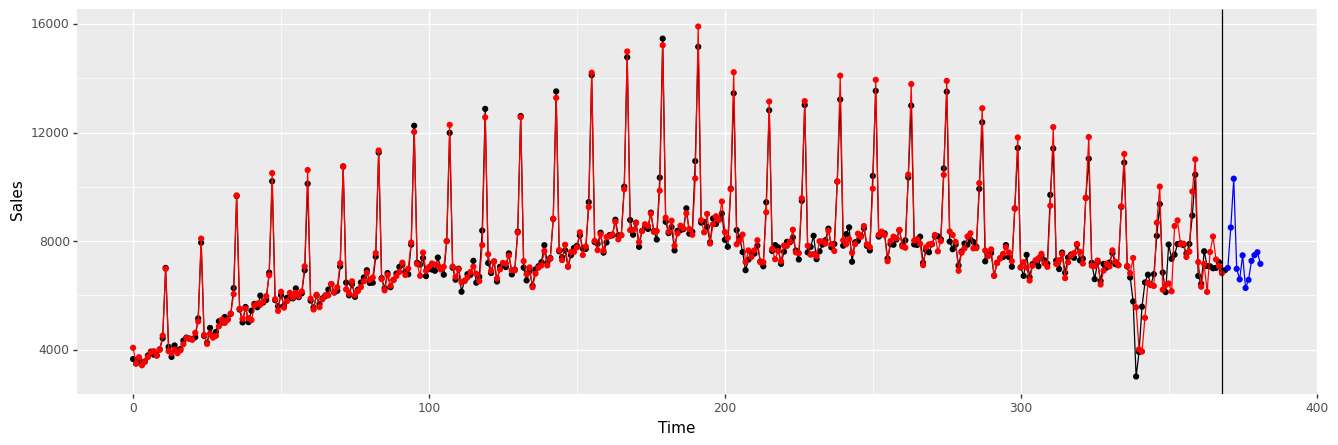

<ggplot: (8777533198017)>

In [ ]:
# Create a a graph of data and overlay fitted values & future forecats. 
(
    ggplot(df2,aes('Time','Sales')) + geom_point() + geom_line()+   # data
 geom_point(aes('Time','M4'),color='red') + geom_line(aes('Time','M4'),color='red') +        # fitted/predicted values
 geom_point(dfFuture,aes('Time','FutureForecast'),color='blue') + geom_line(dfFuture, aes('Time','FutureForecast'),color='blue') 
 + theme(figure_size=(16, 5)) + geom_vline(xintercept = 368)
)

We now use the Exponential Model with all the Sales data available in order to predict the next 12 months of sales (Oct 2022 - Sep 2023). In the visualization above, this forecast can be seen in blue.

In [ ]:
# Create and plot confidence and prediction intervals:
# 95% approximate prediction/confidence interval = predicted value +/- 2*RMSE
RMSE = (M4.sse / len(df))**0.5
df2['LowerBound'] = df2['M4'] - 2*RMSE
df2['UpperBound'] = df2['M4'] + 2*RMSE
dfFuture['LowerBound'] = dfFuture['FutureForecast'] - 2*RMSE
dfFuture['UpperBound'] = dfFuture['FutureForecast'] + 2*RMSE

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


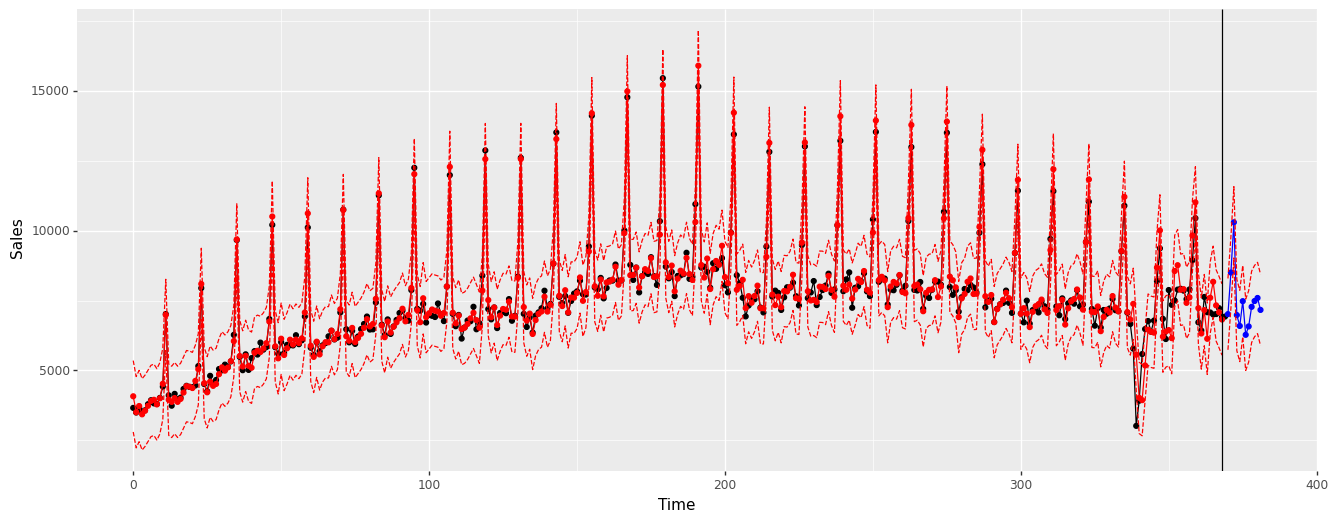

<ggplot: (8777532911489)>

In [ ]:
# Create graph and overlay fitted values, future forecast and conf/pred intervals
CI = 'red'
style='dashed'
(
    ggplot(df2,aes('Time','Sales')) + geom_point() + geom_line() +   # data
 geom_point(aes('Time','M4'),color='red') + geom_line(aes('Time','M4'),color='red') +        # fitted/predicted values
 geom_point(dfFuture,aes('Time','FutureForecast'),color='blue') +  
 geom_line(dfFuture, aes('Time','FutureForecast'),color='blue') + geom_line(aes('Time','LowerBound'),color=CI, linetype=style) + 
 geom_line(aes('Time','UpperBound'),color=CI, linetype=style) + geom_line(dfFuture,aes('Time','LowerBound'),color=CI, linetype=style) + 
 geom_line(dfFuture,aes('Time','UpperBound'),color=CI, linetype=style) + 
 geom_vline(xintercept = 368) +  theme(figure_size=(16,6))
)

We can also find the confidence and prediction intervals for M4 by calculating the RMSE with a 95% confidence interval (2 SD from the mean). Here in the visualization we can see the intervals as the dashed lines.

Since the majority of our actual data points lie within the confidence and prediction intervals, we can conclude that M4 does presents a fairly accurate picture of current and data patterns. While it is very difficult to account for another COVID-like occurrence, I do believe that the forecasts the model offers for the next 12 months are fairly accurate.

# **EXTRA CREDIT 1**

In [ ]:
df2['M5S1'] = (df2['M2S1'] + df2['M3S1']) / 2
df2['M5S2'] = (df2['M2S2'] + df2['M3S2']) / 2
df2['M5S3'] = (df2['M2S3'] + df2['M3S3']) / 2

In order to create an ensemble model for Scenario 2, we will use the Regression Model with lags (M2) and the Exponential Smoothing Model (M3) for each different scenario and combine them.

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df2.loc[df2['Time']<312],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M5S1',color='Prediction1')) + geom_line(aes('Time','M5S1',color='Prediction1')) +
 geom_vline(xintercept = 300) + theme(figure_size=(16, 5)) + ggtitle("Ensemble Model - Scenario 1")
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


<ggplot: (8777533066973)>

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.


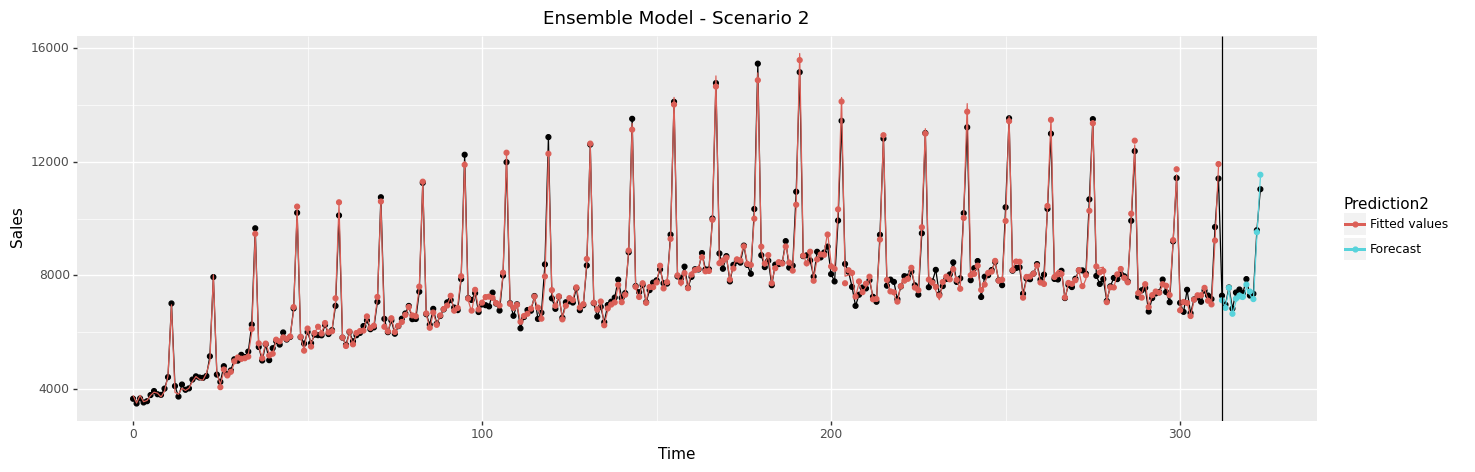

<ggplot: (8777533351405)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<324],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M5S2',color='Prediction2')) + geom_line(aes('Time','M3S2',color='Prediction2')) +
 geom_vline(xintercept = 312) + theme(figure_size=(16, 5)) + ggtitle("Ensemble Model - Scenario 2")
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 25 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 25 rows containing missing values.


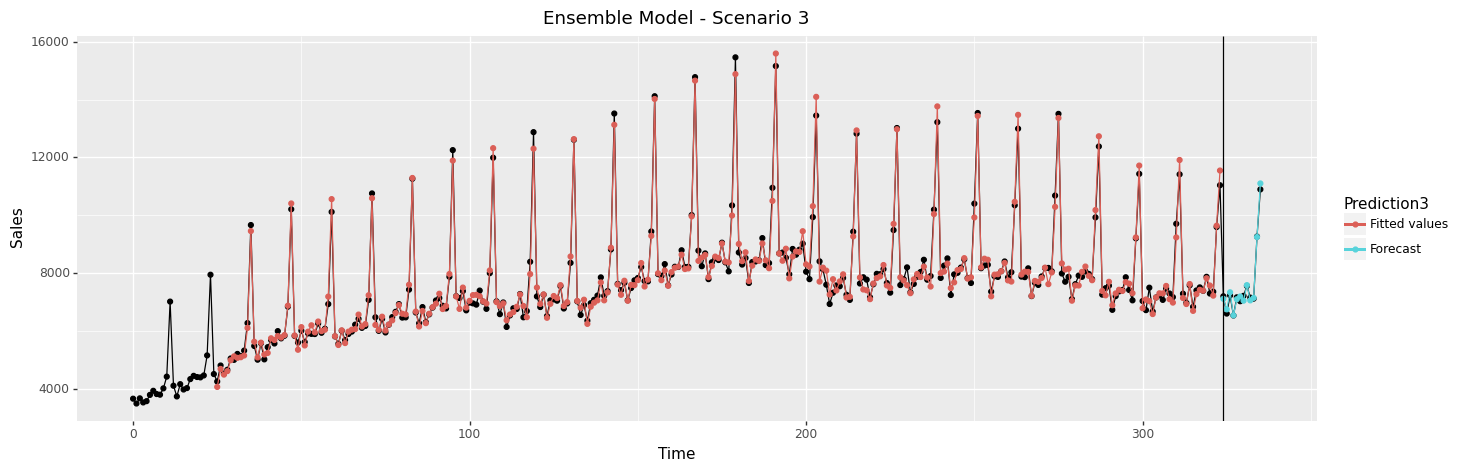

<ggplot: (8777532821001)>

In [ ]:
(
    ggplot(df2.loc[df2['Time']<336],aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M5S3',color='Prediction3')) + geom_line(aes('Time','M5S3',color='Prediction3')) +
 geom_vline(xintercept = 324) + theme(figure_size=(16, 5)) + ggtitle("Ensemble Model - Scenario 3")
)

In [ ]:
print("Ensemble Model - Scenario 1:")
acc_M5S1 = accuracy(df2['Sales'], df2['M5S1'], 299)
acc_M5S1

Ensemble Model - Scenario 1:


RMSE MAPE(%)
Training set  206.27    1.94
Testing set   307.82    3.28

In [ ]:
print("Ensemble Model - Scenario 2:")
acc_M5S2 = accuracy(df2['Sales'], df2['M5S2'], 311)
acc_M5S2

Ensemble Model - Scenario 2:


RMSE MAPE(%)
Training set  209.86     2.0
Testing set   159.12    1.99

In [ ]:
print("Ensemble Model - Scenario 3:")
acc_M5S3 = accuracy(df2['Sales'], df2['M5S3'], 323)
acc_M5S3

Ensemble Model - Scenario 3:


RMSE MAPE(%)
Training set  208.76    1.98
Testing set   100.24    1.16

In [ ]:
print("Average MAPE for M2: " + str((acc_M2S1.iloc[1,1] + acc_M2S2.iloc[1,1] + acc_M2S3.iloc[1,1]) / 3))
print("Average MAPE for M3: " + str((acc_M3S1.iloc[1,1] + acc_M3S2.iloc[1,1] + acc_M3S3.iloc[1,1]) / 3))
print("\nAverage MAPE for M5: " + str((acc_M5S1.iloc[1,1] + acc_M5S2.iloc[1,1] + acc_M5S3.iloc[1,1]) / 3))

Average MAPE for M2: 2.1166666666666667
Average MAPE for M3: 2.4966666666666666

Average MAPE for M5: 2.143333333333333


After running our accuracy function to consider the RMSE and MAPE of M5, we can conclude that the model does not outperform "champion" model M2, as the average MAPE is larger. However, it does outperform M3 on average, as the difference in accuracy scores is lower for M5 than for M3.

# **EXTRA CREDIT 2**

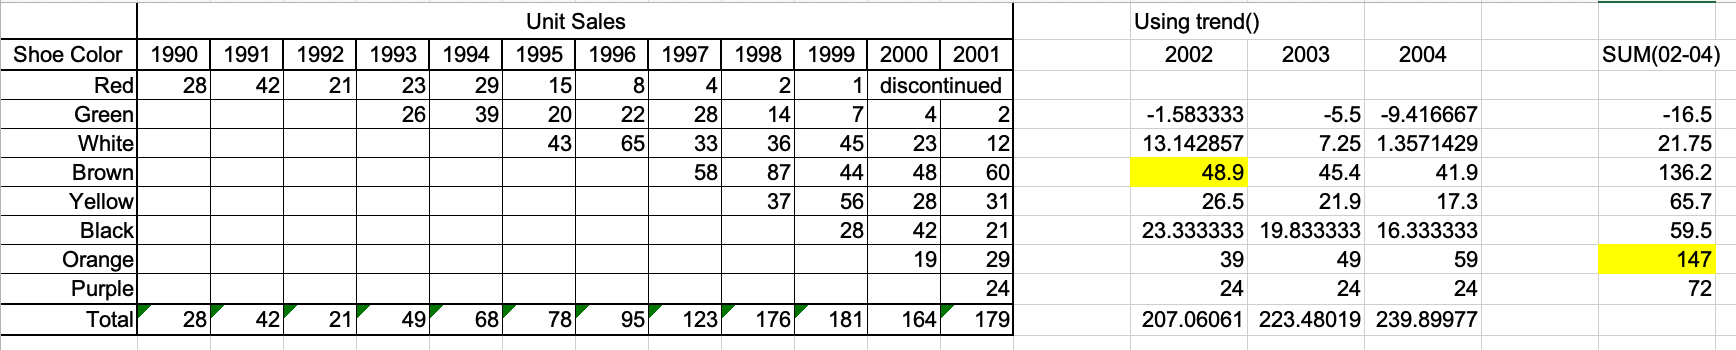

In order to see which colors will sell the most units in the future, we assess the historical data for sales. As red shoes have been discontinued, we do not factor them into our predictions as the values sold 2000 and beyond are 0.

To see how shoe sales evolved in the 2002 - 2004 period, we use the trend() function in excel. This function returns future values along a straight line fit. For example, for the green shoes predictions, we entered *=TREND(E4:M4,E2:M2,O2:Q2)*, which takes all the historical green sales data from 1993 to 2001.

After using the same method with all the different colors, we conclude that **brown shoes will sell the most units in 2002, with 48.9 sales.**

To assess which color will sell the most in the combined 2002-2004 period, we simply sum the 2002, 2003, 2004 columns for each color. We conclude that **orange shoes will sell the most throughout this period, with 147 sales.**

It is important to note that this method might not be particularly accurate. As we only have yearly data, it is impossible to see monthly seasonality trends, and some of the shoe colors have recently been introduced, meaning we do not have a lot of historical data to base our predictions upon (for example orange and purple shoes).

# **EXTRA CREDIT 3**

In [ ]:
# Importing data from github
url = 'https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/ExtraCredit3.csv'
df3 = pd.read_csv(url)
df3.head()

Date  Email  Orders  Shipments  NewCustomers  RepeatOrders
0  1-Jul      0  2258.0     3364.0         659.0        1599.0
1  2-Jul      0  1594.0     3201.0         506.0        1088.0
2  3-Jul      0  1078.0        0.0         333.0         745.0
3  4-Jul      0   605.0        0.0         213.0         392.0
4  5-Jul      0   843.0     1364.0         286.0         557.0

In [ ]:
# Data prep

# Creating time column
df3["Time"] = list(range(0, len(df3)))

In [ ]:
len(df3)

62

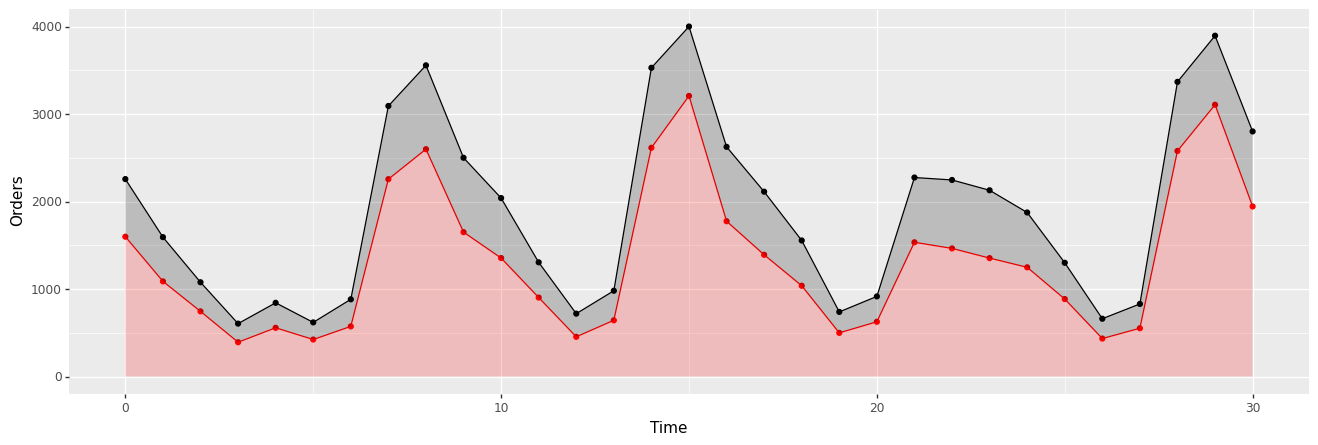

<ggplot: (8777532423885)>

In [ ]:
# Plotting Time Series of Orders and New/Repeat breakdown
(
    ggplot(df3.loc[df3['Time']<31],aes('Time','Orders')) + geom_point() + geom_line()+   # Total Orders
 geom_point(aes('Time','RepeatOrders'),color='red') + geom_line(aes('Time','RepeatOrders'),color='red')   # Repeat orders
 + geom_ribbon(aes(ymin="RepeatOrders", ymax="Orders", x="Time"), fill="black", alpha=0.2) # Fill is new customers
 + geom_ribbon(aes(ymin=0, ymax="RepeatOrders", x="Time"), fill="red", alpha=0.2)
 + theme(figure_size=(16, 5))
)

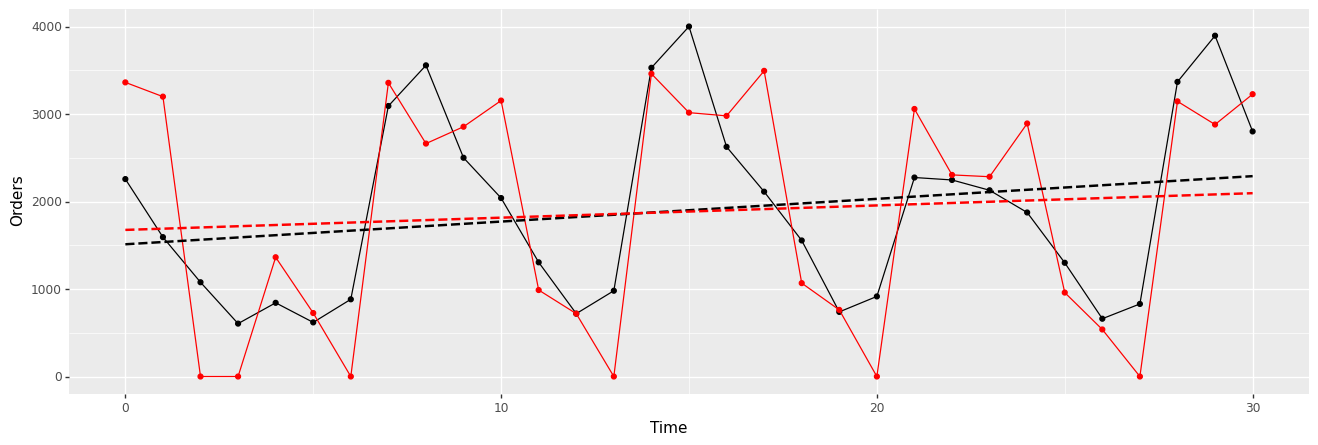

<ggplot: (8777533309653)>

In [ ]:
# Plotting Time Series of Orders and Shipments
(
    ggplot(df3.loc[df3['Time']<31],aes('Time','Orders')) + geom_point() + geom_line()+   # Total Orders
 geom_point(aes('Time','Shipments'),color='red') + geom_line(aes('Time','Shipments'),color='red')   # Shipments
 + theme(figure_size=(16, 5)) + geom_smooth(aes("Time", "Orders"), method='lm',se=False,show_legend=False, linetype="dashed")
 + geom_smooth(aes("Time", "Shipments"), color='red', method='lm',se=False,show_legend=False, linetype="dashed")
)

In the first visualization above, we plot the orders breakdown for the company. The black line is total orders, while the shaded grey space below represents the new customers, and the red line (and shade) is repeat customers. We can see that the business consistently has more return customers than new ones, suggesting the business maybe has a low churn rate and enjoys high consumer loyalty. We can also see in the graph some seasonality. The time periods that match up with the e-mail drop dates seem to have higher order numbers, suggesting that these special offers might encourage customers to purchase. The seasonality also seems to be additive becuase the order increases associated with the email drop dates are all similar.

In the second visualization, we plot the total orders and the shipments (red). The trends for both are slightly positive across time, but since they are not pronounced and evident, we will not include them in our model. We can also observe that shipment numbers behave in a similar way to the order amounts, this might be because the orders are shipped using overnight or second day delivery.

In [ ]:
# Creating Exponential Smoothing model using last 7 days as testing set
# len(df) = 62 -> 62 - 31 (nans) - 7 (last 7 days) = 24 - 1 = 23
M1_e3 = ExponentialSmoothing(df3.loc[:23,'Orders'],seasonal='add',seasonal_periods=7).fit()

# Saving fitted values, predictions and residuals
df3.loc[24:,'M1'] = M1_e3.forecast(7)
df3.loc[:23,'M1'] = M1_e3.fittedvalues
df3['M1residuals'] = M1_e3.resid

df3['Prediction'] = 'Fitted values'
df3.loc[24:,'Prediction'] = 'Forecast'

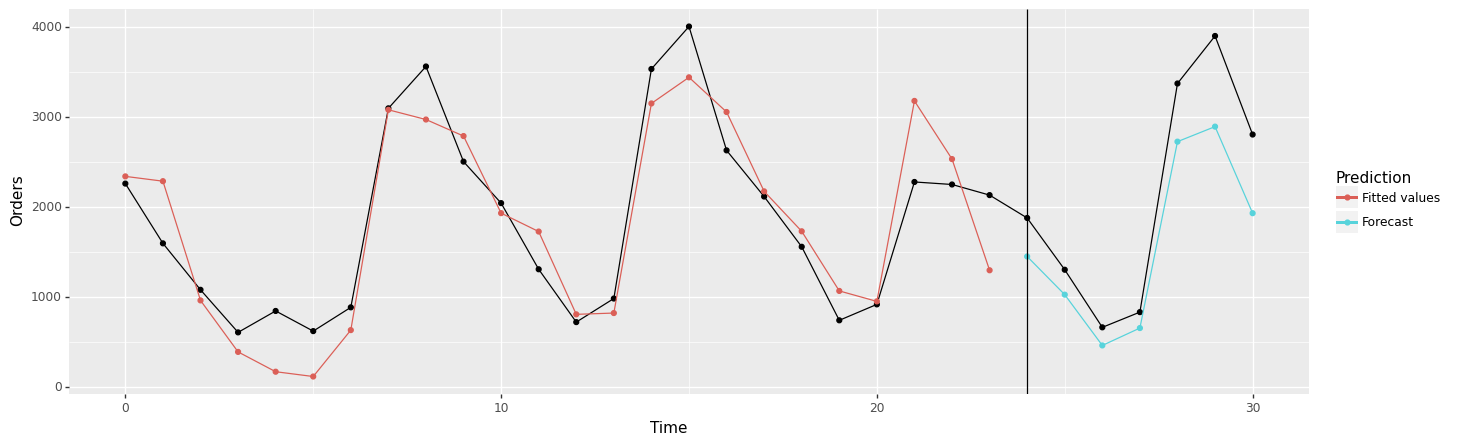

<ggplot: (8777532644481)>

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df3.loc[df3['Time']<31],aes('Time','Orders')) + geom_point() + geom_line()+
 geom_point(aes('Time','M1',color='Prediction')) + geom_line(aes('Time','M1',color='Prediction')) +
 geom_vline(xintercept = 24) + theme(figure_size=(16, 5))
)

We build an exponential smoothing model with no trend factor and an additive seasonality to represent our assessment of initial data patterns. Above, we can see the visualization of the testing set we used (last 7 days of data) and how it matches up to the actual data.

In [ ]:
# Building new accuracy function with ammended train/test split
def accuracy(actual,predicted,n):
    n_train = n
    n_test = n + 7
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (n>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train + 1:n_test],predicted[n_train+ 1:n_test])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train + 1:n_test],predicted[n_train+ 1:n_test])
    return accuracy_metrics

In [ ]:
accuracy(df3['Orders'], df3['M1'], 23)

RMSE MAPE(%)
Training set  398.17   23.18
Testing set   542.09   23.48

In [ ]:
# Using same Exp. Smoothing model with all available data for Orders, Shipments, New Cust. and Repeat Orders
M2_e3 = ExponentialSmoothing(df3.loc[:30,'Orders'],seasonal='add',seasonal_periods=7).fit()
M3_e3 = ExponentialSmoothing(df3.loc[:30,'Shipments'],seasonal='add',seasonal_periods=7).fit()
M4_e3 = ExponentialSmoothing(df3.loc[:30,'NewCustomers'],seasonal='add',seasonal_periods=7).fit()
M5_e3 = ExponentialSmoothing(df3.loc[:30,'RepeatOrders'],seasonal='add',seasonal_periods=7).fit()

# Saving fitted values and predictions
df3.loc[31:,'M2'] = M2_e3.forecast(len(df3.loc[31:]))
df3.loc[:30,'M2'] = M2_e3.fittedvalues

df3.loc[31:,'M3'] = M3_e3.forecast(len(df3.loc[31:]))
df3.loc[:30,'M3'] = M3_e3.fittedvalues

df3.loc[31:,'M4'] = M4_e3.forecast(len(df3.loc[31:]))
df3.loc[:30,'M4'] = M4_e3.fittedvalues

df3.loc[31:,'M5'] = M5_e3.forecast(len(df3.loc[31:]))
df3.loc[:30,'M5'] = M5_e3.fittedvalues

# Creating new Prediction column
df3['Prediction2'] = 'Fitted values'
df3.loc[31:,'Prediction2'] = 'Forecast'

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


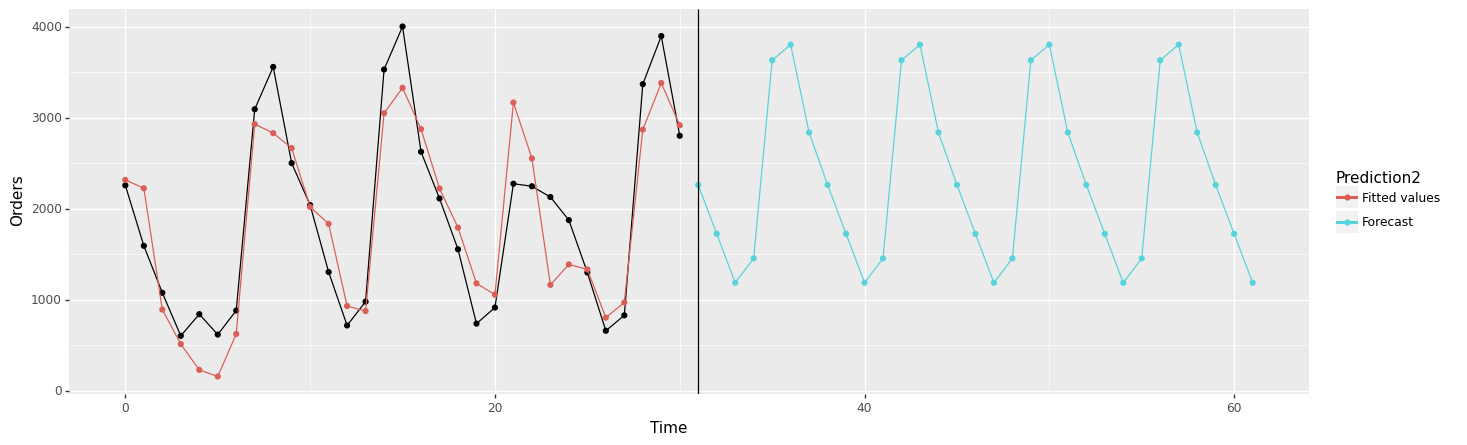

<ggplot: (8777536013873)>

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df3,aes('Time','Orders')) + geom_point() + geom_line()+
 geom_point(aes('Time','M2',color='Prediction2')) + geom_line(aes('Time','M2',color='Prediction2')) +
 geom_vline(xintercept = 31) + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


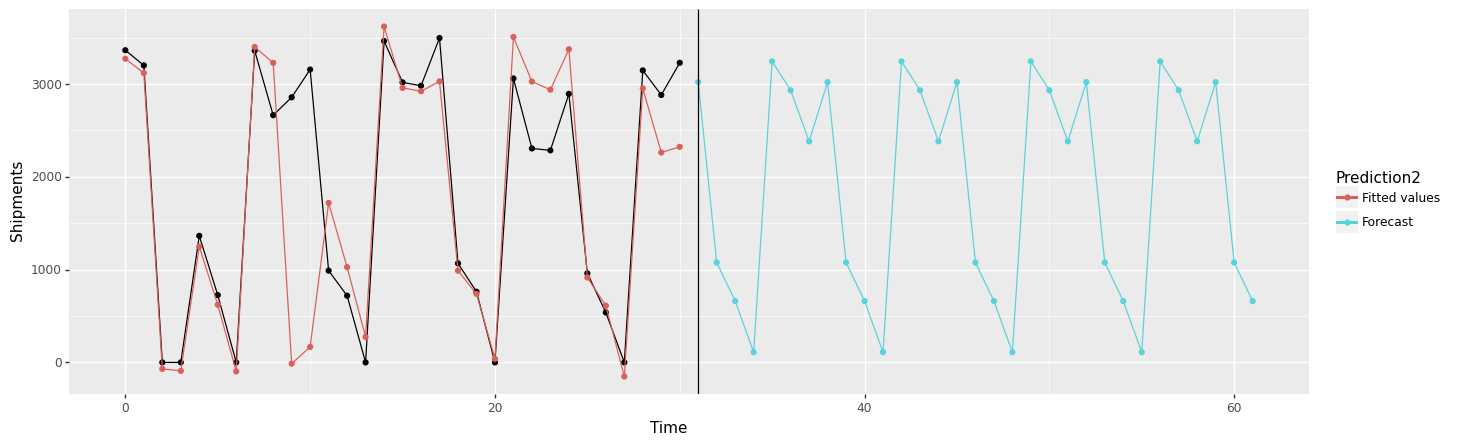

<ggplot: (8777536013925)>

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df3,aes('Time','Shipments')) + geom_point() + geom_line()+
 geom_point(aes('Time','M3',color='Prediction2')) + geom_line(aes('Time','M3',color='Prediction2')) +
 geom_vline(xintercept = 31) + theme(figure_size=(16, 5))
)

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df3,aes('Time','NewCustomers')) + geom_point() + geom_line()+
 geom_point(aes('Time','M4',color='Prediction2')) + geom_line(aes('Time','M4',color='Prediction2')) +
 geom_vline(xintercept = 31) + theme(figure_size=(16, 5))
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


<ggplot: (8777535721273)>

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


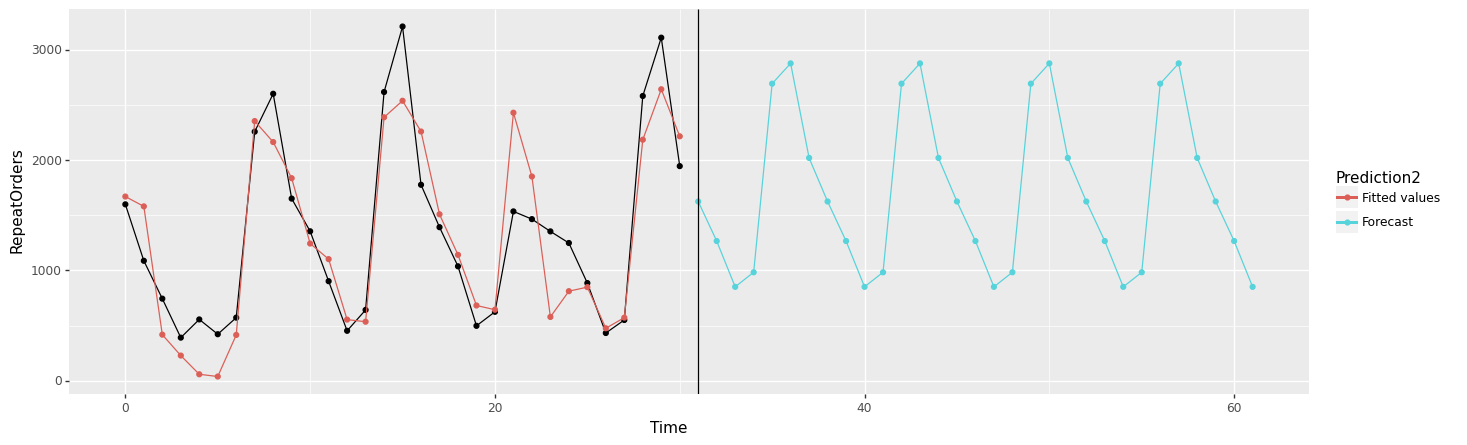

<ggplot: (8777535872957)>

In [ ]:
# Create a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df3,aes('Time','RepeatOrders')) + geom_point() + geom_line()+
 geom_point(aes('Time','M5',color='Prediction2')) + geom_line(aes('Time','M5',color='Prediction2')) +
 geom_vline(xintercept = 31) + theme(figure_size=(16, 5))
)

We utilize the same model base with no trend and additive seasonality as all 4 data columns seem to follow a similar pattern. Above are the results with fitted values, actual data and forecast for the next month.

# **EXTRA CREDIT 4**

In [ ]:
# Backgammon Rules:
# 2 dice, 2 pieces moving
# Rolling doubles = move 2*2 = move 4 times
# Bet $100, need double threes or better to win game
# No double threes or better, certain loss

In [ ]:
dice = list(range(1,7))
roll1 = []
roll2 = []
value_mul = [1] * 36
roll_value = []
outcome = []

for i in dice:
  for n in range(6):
    roll1.append(i)
  for i in dice:
    roll2.append(i)

for i in range(len(roll1)):
  if roll1[i] == roll2[i]:
    value_mul[i] = 2
  
  rval = (roll1[i] + roll2[i]) * value_mul[i]
  roll_value.append(rval)

  if rval >= 12:
    outcome.append("Win")
  else:
    outcome.append("Loss")

print(roll1)
print(roll2)
print(value_mul)
print(roll_value)
print(outcome)

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]
[1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
[2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2]
[4, 3, 4, 5, 6, 7, 3, 8, 5, 6, 7, 8, 4, 5, 12, 7, 8, 9, 5, 6, 7, 16, 9, 10, 6, 7, 8, 9, 20, 11, 7, 8, 9, 10, 11, 24]
['Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Win', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Win', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Win', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Loss', 'Win']


For this problem, we use loops to populate lists that include all the possible rolls and the "value" of every combination (given that rolling doubles means you can move twice the amount). We also make a list with the outcome of each roll and we will put all in a dataframe.

In [ ]:
df4 = pd.DataFrame()

df4["Dice1"] = roll1
df4["Dice2"] = roll2
df4["RollValue"] = roll_value
df4["Outcome"] = outcome

df4

Dice1  Dice2  RollValue Outcome
0       1      1          4    Loss
1       1      2          3    Loss
2       1      3          4    Loss
3       1      4          5    Loss
4       1      5          6    Loss
5       1      6          7    Loss
6       2      1          3    Loss
7       2      2          8    Loss
8       2      3          5    Loss
9       2      4          6    Loss
10      2      5          7    Loss
11      2      6          8    Loss
12      3      1          4    Loss
13      3      2          5    Loss
14      3      3         12     Win
15      3      4          7    Loss
16      3      5          8    Loss
17      3      6          9    Loss
18      4      1          5    Loss
19      4      2          6    Loss
20      4      3          7    Loss
21      4      4         16     Win
22      4      5          9    Loss
23      4      6         10    Loss
24      5      1          6    Loss
25      5      2          7    Loss
26      5      3          8    Loss
27      5      4          9    Loss
28      5      5         20     Win
29      5      6         11    Loss
30      6      1          7    Loss
31      6      2          8    Loss
32      6      3          9    Loss
33      6      4         10    Loss
34      6      5         11    Loss
35      6      6         24     Win

In [ ]:
df4.groupby('Outcome').count()

Dice1  Dice2  RollValue
Outcome                         
Loss        32     32         32
Win          4      4          4

In [ ]:
print("The expected value of a win (rolling double 3s or better) is: " + str(4/(32+4)))
print("The minimum amount you should accept / amount I would offer to call off the bet is: $" + str(round(100 * (1 - (4/(32+4))), 2)))

The expected value of a win (rolling double 3s or better) is: 0.1111111111111111
The minimum amount you should accept / amount I would offer to call off the bet is: $88.89


In order to conclude on an amount that we should pay to call off the bet without rolling the dice one last time, we must find the expected value of a win (rolling double 3s or better). To do this we simply use our dataframe and group it by our Outcome column and count the occurences of win/lose.

Given that there are 36 possible combinations for a dice roll in backgammon, and only 4 of these combinations will result in a win, **our expected value of a win is 4 /36 = 0.111**

To calculate the amount I am willing to offer, or in other words, the minimum amount you should accept to call off the bet, **we multiply the bet amount by the expected value of a loss: 100 x (1 - 0.111) = $88.89**